# DSPM Final Project (95-451 Fall 2021)

#### Project Choice: NLP Analysis of Consumer Posts on Samsung Galaxy S8 vs. Iphone 8, Iphone X
#### Name: Shaily Shah, Ami Kotia, Abhishek Parikh
#### Andrew Id: shailys, akotia, akparikh

##### Note: The images are getting distorted due to pyLDAvis library used for visualizing the LDA topics. Also, for any reasons, if you are not able to see the LDA clustering visulaization towards the end of the notebook then it is a problem of the library. You can re-run the notebook (will take ~10 mins) and see those graphs.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import datetime

# https://www.cnet.com/tech/mobile/samsung-galaxy-s8-launch-date-official-march-29-in-ny/
SAMSUNG_ANNOUNCEMENT_DATE = datetime.datetime.strptime("02-26-2017", "%m-%d-%Y")
SAMSUNG_LAUNCH_DATE = datetime.datetime.strptime("03-29-2017", "%m-%d-%Y")

# https://www.apple.com/newsroom/2017/09/iphone-8-and-iphone-8-plus-a-new-generation-of-iphone/
# https://www.apple.com/newsroom/2017/09/the-future-is-here-iphone-x/
APPLE_ANNOUNCEMENT_DATE = datetime.datetime.strptime("09-12-2017", "%m-%d-%Y")
APPLE_LAUNCH_DATE = datetime.datetime.strptime("09-22-2017", "%m-%d-%Y")

In [3]:
import os
import pandas as pd
import math
import numpy as np
import ast
from scipy import stats
from matplotlib import pyplot as plt
import re
import itertools
import collections
import spacy
import nltk
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,5)
pd.set_option('display.max_rows', 4000)

In [4]:
!pip install gensim
!pip install pyLDAvis

# downloading necessary NLTK model
nltk.download('punkt')
nltk.download('vader_lexicon')

# downloading necessary spaCy model
# import sys
!pip install wordcloud
nlp = spacy.load('en_core_web_sm')

from wordcloud import WordCloud

from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /Users/abhishek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abhishek/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
#Read data files and combine into one single dataframe
if not os.path.isfile('merged_data.csv'):
    df1 = pd.read_excel('T Only 3_1_2017 thru 6_30_2017 Random Stream (1).xlsx', engine="openpyxl")
    df2 = pd.read_excel('T Only 9_1_2017 thru 10_31_2017 Random Stream (1).xlsx',engine="openpyxl")
    df3 = pd.read_excel('Stream (2).xlsx',engine="openpyxl")
    df4 = pd.read_excel('Stream (3).xlsx',engine="openpyxl")
    df5 = pd.read_excel('Stream (4).xlsx',engine="openpyxl")
    df6 = pd.read_excel('Stream (5).xlsx',engine="openpyxl")
    df7 = pd.read_excel('Stream (6).xlsx',engine="openpyxl")
    df8 = pd.read_excel('Stream (7).xlsx',engine="openpyxl")
    df9 = pd.read_excel('Stream (8).xlsx',engine="openpyxl")
    df10 = pd.read_excel('Stream (9).xlsx',engine="openpyxl")
    df11 = pd.read_excel('Stream (10).xlsx',engine="openpyxl")
    df12 = pd.read_excel('Stream (11).xlsx',engine="openpyxl")

    df1.drop(df1.tail(10).index, inplace = True)
    df2.drop(df2.tail(10).index, inplace = True)
    df3.drop(df3.tail(10).index, inplace = True)
    df4.drop(df4.tail(10).index, inplace = True)
    df5.drop(df5.tail(10).index, inplace = True)
    df6.drop(df6.tail(10).index, inplace = True)
    df7.drop(df7.tail(10).index, inplace = True)
    df8.drop(df8.tail(10).index, inplace = True)
    df9.drop(df9.tail(10).index, inplace = True)
    df10.drop(df10.tail(10).index, inplace = True)
    df11.drop(df11.tail(10).index, inplace = True)
    df12.drop(df12.tail(10).index, inplace = True)
    
    listDF = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12]
    oldData = pd.concat(listDF)
    oldData.to_csv('merged_data.csv')
else:
    oldData = pd.read_csv('merged_data.csv', index_col=0)


In [6]:
oldData.shape

(512701, 41)

In [7]:
#Columns and their null value percentage of all data. 
total = (oldData.isnull().sum()).sort_values(ascending=False)
percent_missing = (oldData.isnull().sum() / len(oldData)*100).sort_values(ascending=False)
oldData_null_df = pd.DataFrame({'total': total,
                                 'percent_missing': percent_missing})

oldData_null_df

total  percent_missing
Ratings and Scores                      512701       100.000000
Product Hierarchy                       512701       100.000000
Post Dislikes                           512701       100.000000
Post Views                              512701       100.000000
Tags                                    512701       100.000000
Author Location - Other                 512652        99.990443
Quoted Author Handle                    512392        99.939731
Quoted Author Name                      512392        99.939731
Quoted Post                             512392        99.939731
Author Location - City 2                512387        99.938756
Author Location - State/Province 2      512350        99.931539
Author Location - Country 2             512293        99.920421
Post Shares                             511533        99.772187
Rating                                  510423        99.555686
Professions                             505451        98.585920
Product Name                            501303        97.776872
Interests                               500516        97.623371
Post Comments                           482082        94.027903
Author Location - City 1                479200        93.465782
Author Location - State/Province 1      473776        92.407856
Negative Objects                        463046        90.315018
Post Likes                              462448        90.198381
Total Engagements                       460227        89.765185
Positive Objects                        405794        79.148276
Author Location - Country 1             335201        65.379432
Author ID                               306982        59.875444
Author Handle                           306595        59.799961
Title                                   208814        40.728222
Author URL                              149410        29.141741
Author Name                             132830        25.907888
Source Type                              19528         3.808848
Post Type                                19528         3.808848
Media Type                               19528         3.808848
Richness                                 19528         3.808848
URL                                      19528         3.808848
Domain                                   19528         3.808848
Author Gender                            19528         3.808848
No. of Followers/Daily Unique Visitors   19528         3.808848
Post ID                                  19527         3.808653
Published Date (GMT-04:00) New York          1         0.000195
Sound Bite Text                              1         0.000195

In [8]:
newData = oldData.copy()

#Only grabbed columns that with less than 20% null values but also remove irrelevant columns like columns with author 
#info

newData = oldData[['Post ID','Sound Bite Text','Source Type','Post Type','Media Type','URL',
                   'Domain','Published Date (GMT-04:00) New York','Author Gender',
                   'No. of Followers/Daily Unique Visitors','Richness']]

In [9]:
#Keeping only original post type rows and removing replies and comments
newData = newData[newData['Post Type'] == 'Original'] 

In [10]:
newData.duplicated().sum()

617

In [11]:
#Remove duplicated rows 
dupRemoved_newData = newData.copy()
print(dupRemoved_newData.shape)
dupRemoved_newData = dupRemoved_newData.drop_duplicates(keep='last')
print(dupRemoved_newData.shape)
print(dupRemoved_newData.dtypes)

(410270, 11)
(409653, 11)
Post ID                                    object
Sound Bite Text                            object
Source Type                                object
Post Type                                  object
Media Type                                 object
URL                                        object
Domain                                     object
Published Date (GMT-04:00) New York        object
Author Gender                              object
No. of Followers/Daily Unique Visitors    float64
Richness                                  float64
dtype: object


<AxesSubplot:>

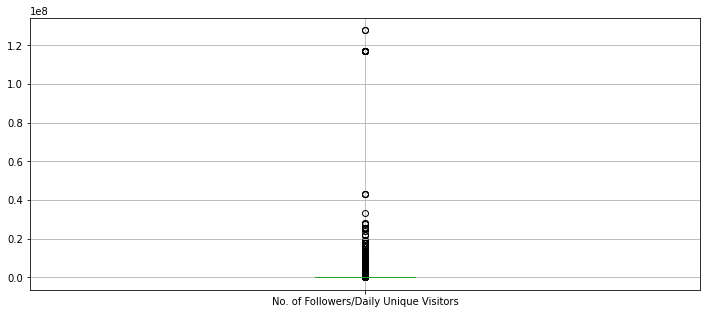

In [12]:
dupRemoved_newData.boxplot(column = 'No. of Followers/Daily Unique Visitors')

array([[<AxesSubplot:title={'center':'No. of Followers/Daily Unique Visitors'}>]],
      dtype=object)

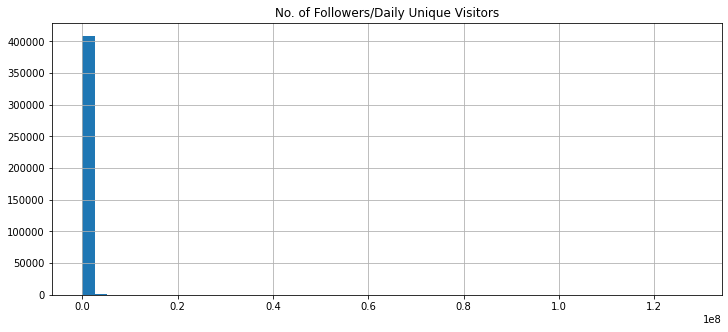

In [13]:
#Using Histogram Plot to see outliers for Num of Followers column
#Majority of the data falls under No. of Followers/Daily Unique Visitors < 10000
dupRemoved_newData.hist(column = 'No. of Followers/Daily Unique Visitors',bins=50)

In [14]:
highFolRemoved_newData = dupRemoved_newData[dupRemoved_newData['No. of Followers/Daily Unique Visitors'] <10000]
highFolRemoved_newData.shape

(389507, 11)

In [15]:
highFolRemoved_newData.describe().T

count        mean         std  min  \
No. of Followers/Daily Unique Visitors  389507.0  110.349927  701.979883  0.0   
Richness                                389507.0    1.583566    1.371902  0.0   

                                        25%  50%  75%     max  
No. of Followers/Daily Unique Visitors  0.0  0.0  0.0  9991.0  
Richness                                0.0  1.0  2.0    12.0

In [16]:
cleanData = highFolRemoved_newData[(np.abs(stats.zscore
                                           (highFolRemoved_newData['No. of Followers/Daily Unique Visitors'])) <= 3)]

print(cleanData.shape)

(383666, 11)


In [17]:
#Check for null values in columns if there are any after removing duplicates, outliers, keeping only original reviews,
# and reviews of accounts with less than 10000 followers 
print(cleanData.isnull().sum()) #no null values

Post ID                                   0
Sound Bite Text                           0
Source Type                               0
Post Type                                 0
Media Type                                0
URL                                       0
Domain                                    0
Published Date (GMT-04:00) New York       0
Author Gender                             0
No. of Followers/Daily Unique Visitors    0
Richness                                  0
dtype: int64


In [18]:
#Remove duplicate Sound Bite text reviews as they may be retweets or reposts and show up as original reviews
cleanData = cleanData.drop_duplicates(subset=['Sound Bite Text'], keep='first')
print(cleanData.shape) #60000 duplicate text reviews

(322577, 11)


In [19]:
# Removing sound bites of source type "Comments"
cleanData = cleanData.loc[~(cleanData['Source Type'] == "Comments")]

In [20]:
cleanData.columns.values

array(['Post ID', 'Sound Bite Text', 'Source Type', 'Post Type',
       'Media Type', 'URL', 'Domain',
       'Published Date (GMT-04:00) New York', 'Author Gender',
       'No. of Followers/Daily Unique Visitors', 'Richness'], dtype=object)

In [21]:
source_df = cleanData.groupby(['Source Type']).size().reset_index()
source_df

Source Type       0
0                  Blogs  135740
1       Consumer Reviews   10430
2               Facebook    1469
3                 Forums   37949
4              Instagram   40592
5  Other Social Networks      23
6                 Tumblr   67168
7                Twitter   21537

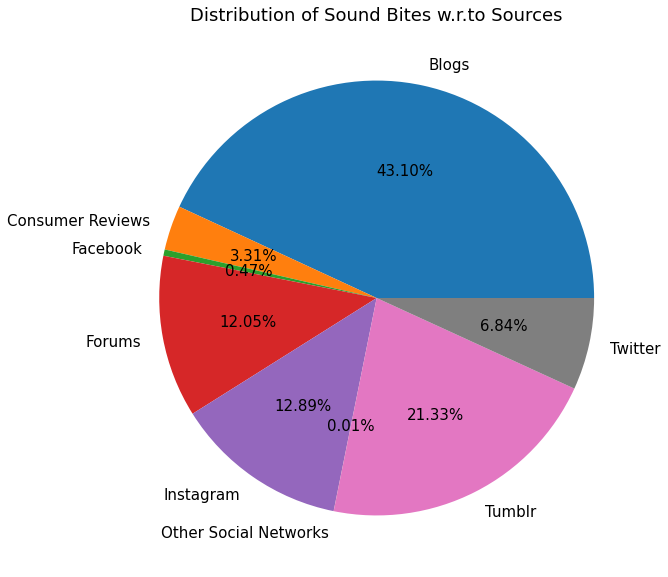

In [22]:
plt.rcParams["figure.figsize"] = (25,10)
plt.rcParams['font.size'] = 15

lbls = source_df['Source Type'].tolist()
vals = np.array(source_df[0].tolist())
plt.pie(vals, labels=lbls, autopct='%.2f%%')
plt.title("Distribution of Sound Bites w.r.to Sources")
plt.show()

In [23]:
processedData = cleanData.copy(deep=True)

In [24]:
def cleanText(text):
    # combining multiple white space characters into one
    _intr = re.sub(r'\s+', ' ', text)
    # keeping only alphanumeric, hashtags, exclamations, full stop and dollar sign in the text
#     final = re.sub(r'[^a-zA-Z0-9@$#!\.\s{1}]', '', _intr)
    #_intr = re.findall('((?:(?<=[^a-zA-Z0-9]){0,}(?:(?:https?\:\/\/){0,1}(?:[a-zA-Z0-9\%]{1,}\:[a-zA-Z0-9\%]{1,}[@]){,1})(?:(?:\w{1,}\.{1}){1,5}(?:(?:[a-zA-Z]){1,})|(?:[a-zA-Z]{1,}\/[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\:[0-9]{1,4}){1})){1}(?:(?:(?:\/{0,1}(?:[a-zA-Z0-9\-\_\=\-]){1,})*)(?:[?][a-zA-Z0-9\=\%\&\_\-]{1,}){0,1})(?:\.(?:[a-zA-Z0-9]){0,}){0,1})', _intr)
    # urls = re.findall('((?:(?<=[^a-zA-Z0-9]){0,}(?:(?:https?\:\/\/){0,1}(?:[a-zA-Z0-9\%]{1,}\:[a-zA-Z0-9\%]{1,}[@]){,1})(?:(?:\w{1,}\.{1}){1,5}(?:(?:[a-zA-Z]){1,})|(?:[a-zA-Z]{1,}\/[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\:[0-9]{1,4}){1})){1}(?:(?:(?:\/{0,1}(?:[a-zA-Z0-9\-\_\=\-]){1,})*)(?:[?][a-zA-Z0-9\=\%\&\_\-]{1,}){0,1})(?:\.(?:[a-zA-Z0-9]){0,}){0,1})', text)
    #remove special characters and links
    final = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",_intr)
    return final.strip()

In [25]:
processedData['Processed Sound Bite'] = processedData['Sound Bite Text'].apply(lambda t: cleanText(t))
processedData['timestamp'] = pd.to_datetime(processedData['Published Date (GMT-04:00) New York'])
processedData['date'] = pd.to_datetime(processedData['Published Date (GMT-04:00) New York'],format="%b %d, %Y %I:%M:%S %p").dt.date
processedData['week'] = processedData['timestamp'].dt.weekofyear

In [26]:
processedData.shape

(314908, 15)

# Categorization

In [27]:
if not os.path.isfile('processed_data.csv'):
    sia = SentimentIntensityAnalyzer()
    processedData['sentiment_score'] = processedData['Processed Sound Bite'].apply(lambda s: float(sia.polarity_scores(s)['compound']))
    processedData.to_csv('processed_data.csv')
else:
    processedData = pd.read_csv('processed_data.csv', index_col=0)
    

In [28]:
processedData.shape

(314908, 16)

In [29]:
if not (os.path.isfile('apple_data.csv') and os.path.isfile('samsung_data.csv')):
    tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=1000,
                                stop_words='english')
    tf = tf_vectorizer.fit_transform(processedData['Processed Sound Bite'])

    num_topics = 2
    lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
    lda.fit(tf)

    #Categorizes the data into 2 topics - Apple and Samsung with LDA
    topic_assignment = lda.transform(tf)

    #Create 4 separate dfs for different product types by using keywords to split data 
    classification = np.argmax(topic_assignment, axis = 1)
    apple_data = processedData.iloc[[i for i in range(len(classification)) if classification[i] == 1]]
    samsung_data = processedData.iloc[[i for i in range(len(classification)) if classification[i] == 0]]
    apple_data.to_csv('apple_data.csv')
    samsung_data.to_csv('samsung_data.csv')
else:
    apple_data = pd.read_csv('apple_data.csv', index_col=0)
    samsung_data = pd.read_csv('samsung_data.csv', index_col=0)
    

In [30]:
iphone8_keywords = ['iphone8','iphone 8', 'plus']
iphonex_keywords = ['iphonex', 'iphone x', 'iphone 10','iphone10']

iphone_8_data = apple_data[apple_data['Processed Sound Bite'].str.contains('|'.join(iphone8_keywords), case=False)]
iphone_x_data = apple_data[apple_data['Processed Sound Bite'].str.contains('|'.join(iphonex_keywords), case=False)]

In [31]:
data_dict = {
    'Apple': apple_data,
    'Samsung': samsung_data,
    'Apple iPhone X': iphone_x_data,
    'Apple iPhone 8': iphone_8_data
}

launch_dates = {'samsung':datetime.datetime(2017,3,29), 'apple':datetime.datetime(2017,9,22)}
start_dates = {'samsung':datetime.datetime(2017,2,1), 'apple':datetime.datetime(2017,8,1)}
end_dates = {'samsung':datetime.datetime(2017,7,1), 'apple':datetime.datetime(2017,12,31)}

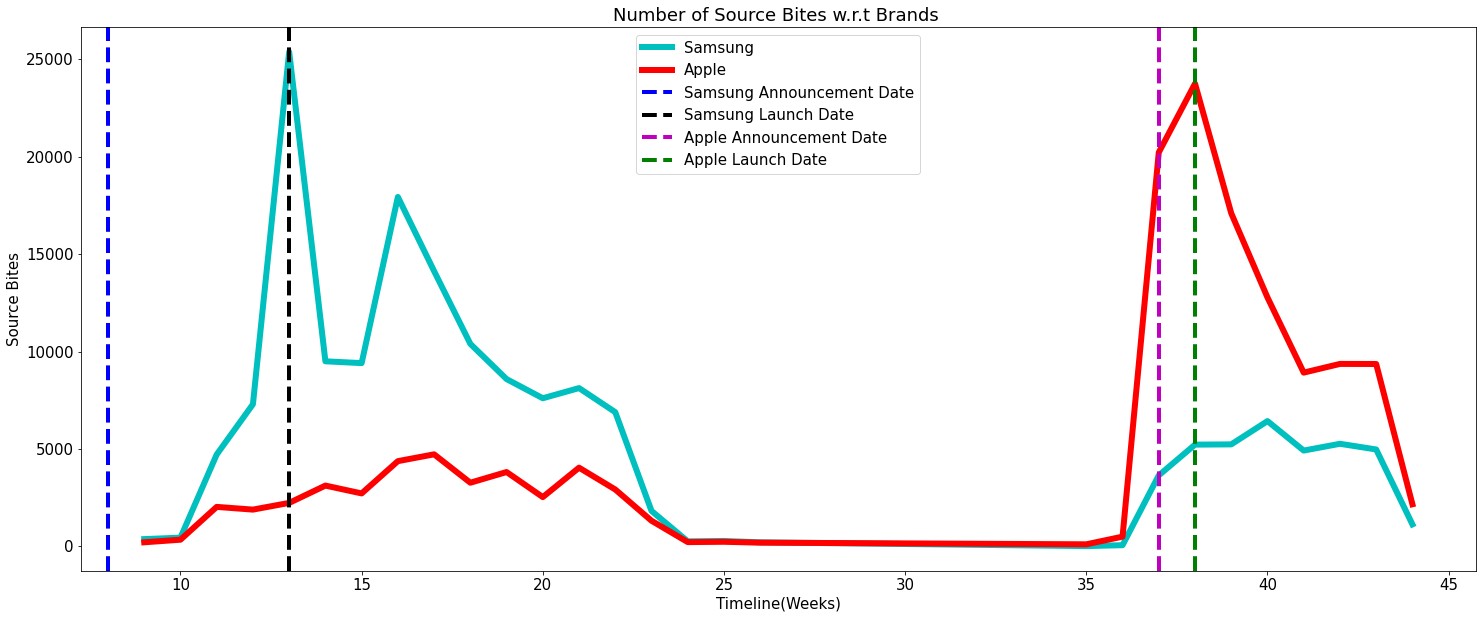

In [32]:
df_apple_week_freq = apple_data.groupby('week').size().reset_index()
df_samsung_week_freq = samsung_data.groupby('week').size().reset_index()

plt.plot(df_samsung_week_freq['week'].tolist(), df_samsung_week_freq[0].tolist(), 'c', linewidth=6, markersize=12,label='Samsung')
plt.plot(df_apple_week_freq['week'].tolist(), df_apple_week_freq[0].tolist(), 'r', linewidth=6, markersize=12,label='Apple')
plt.axvline(x=SAMSUNG_ANNOUNCEMENT_DATE.isocalendar().week, linewidth=4, c='b',label='Samsung Announcement Date',linestyle='dashed')
plt.axvline(x=SAMSUNG_LAUNCH_DATE.isocalendar().week, linewidth=4, c='k',label ='Samsung Launch Date',linestyle='dashed')
plt.axvline(x=APPLE_ANNOUNCEMENT_DATE.isocalendar().week, linewidth=4, c='m',label='Apple Announcement Date',linestyle='dashed')
plt.axvline(x=APPLE_LAUNCH_DATE.isocalendar().week, linewidth=4, c='g',label='Apple Launch Date',linestyle='dashed')
plt.xlabel("Timeline(Weeks)")
plt.ylabel("Source Bites")
plt.title("Number of Source Bites w.r.t Brands ")
plt.legend(loc="upper center")
plt.show()

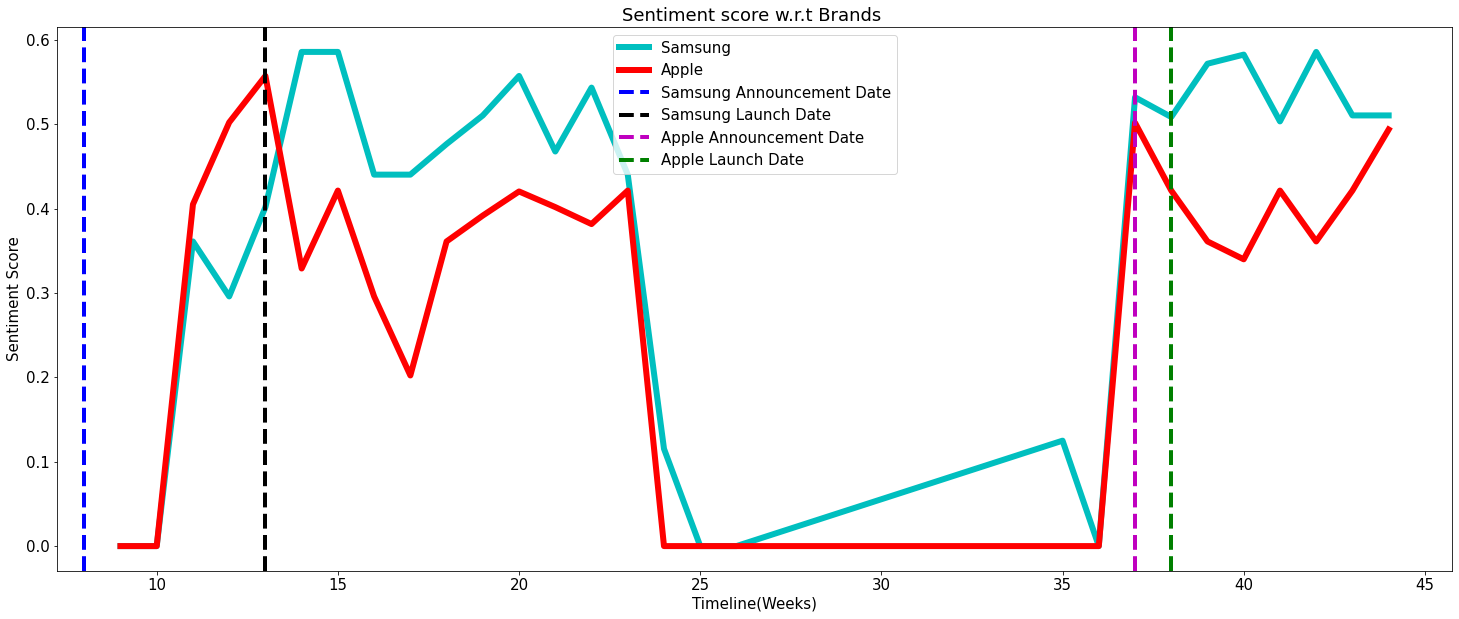

In [33]:
# validation: 
# https://versus.com/en/apple-iphone-8-vs-apple-iphone-x-vs-samsung-galaxy-note-8
# https://www.zdnet.com/article/iphone-x-and-note-8-compared-the-ultimate-guide-for-business-users/
# https://www.gadgetsnow.com/compare-mobile-phones/Apple-iPhone-X-vs-Samsung-Galaxy-Note-8

df_apple_week_sentiment = apple_data.groupby('week', as_index=False)['sentiment_score'].median()
df_samsung_week_sentiment = samsung_data.groupby('week', as_index=False)['sentiment_score'].median()

plt.plot(df_samsung_week_sentiment['week'].tolist(), df_samsung_week_sentiment['sentiment_score'].tolist(), 'c', linewidth=6, markersize=12,label='Samsung')
plt.plot(df_apple_week_sentiment['week'].tolist(), df_apple_week_sentiment['sentiment_score'].tolist(), 'r', linewidth=6, markersize=12,label='Apple')
plt.axvline(x=SAMSUNG_ANNOUNCEMENT_DATE.isocalendar().week, linewidth=4, c='b',label='Samsung Announcement Date',linestyle='dashed')
plt.axvline(x=SAMSUNG_LAUNCH_DATE.isocalendar().week, linewidth=4, c='k',label ='Samsung Launch Date',linestyle='dashed')
plt.axvline(x=APPLE_ANNOUNCEMENT_DATE.isocalendar().week, linewidth=4, c='m',label='Apple Announcement Date',linestyle='dashed')
plt.axvline(x=APPLE_LAUNCH_DATE.isocalendar().week, linewidth=4, c='g',label='Apple Launch Date',linestyle='dashed')
# plt.xticks(processedData['week'].unique.tolist())
plt.xlabel("Timeline(Weeks)")
plt.ylabel("Sentiment Score")
plt.title("Sentiment score w.r.t Brands ")
plt.legend(loc="upper center")
plt.show()

In [34]:
def product_launch_diff(data_dict):
    
    launch_df = {}
    for product, data in data_dict.items(): 
        
        data['date'] = pd.to_datetime(data['date'], format='%Y %m %d')

        brand = product.split(' ')[0].lower()
        launch, start, end = launch_dates[brand], start_dates[brand], end_dates[brand]
        prelaunch_df = data[(data['date'] >= start) & (data['date'] < launch)]
        postlaunch_df = data[(data['date'] >= launch) & (data['date'] <= end)]

        print('Pre Launch sentiment for %s is %s' %(product, np.round(prelaunch_df['sentiment_score'].mean(), 2)))
        print('Post Launch sentiment for %s is %s' %(product, np.round(postlaunch_df['sentiment_score'].mean(), 2)))

        launch_df.update({product : [prelaunch_df, postlaunch_df]})
             
    return (launch_df)

plt.rcParams['figure.constrained_layout.use'] = True
def display_launch_diff(launch_df):
    num_prods = len(launch_df)
    labels = ('Pre Launch', 'Post Launch')
    fig, axes = plt.subplots(num_prods, 1, sharey='row', figsize=(20, 5*num_prods))
    fig.suptitle('Sentiment Analysis before and after product launch')
    i = 0
    for product, data in launch_df.items(): 
        if 'apple' in product.lower():
            color = 'm'
            axes[i].axvline(x=APPLE_ANNOUNCEMENT_DATE, linewidth=4, c='k',label='Apple Announcement Date',linestyle='dashed')
            axes[i].axvline(x=APPLE_LAUNCH_DATE, linewidth=4, c='y',label='Apple Release Date',linestyle='dashed')
        else:
            color = 'c'
            axes[i].axvline(x=SAMSUNG_ANNOUNCEMENT_DATE, linewidth=4, c='k',label='Samsung Announcement Date',linestyle='dashed')
            axes[i].axvline(x=SAMSUNG_LAUNCH_DATE, linewidth=4, c='y',label='Samsung Release Date',linestyle='dashed')
            
        axes[i].plot(data[0].groupby(['date'])['sentiment_score'].mean(), c = color, label='Pre Launch')
        
        if 'apple' in product.lower():
            color = 'r'
        else:
            color = 'b'
        axes[i].plot(data[1].groupby(['date'])['sentiment_score'].mean(), c = color, label='Post Launch')
        axes[i].set(ylabel='Sentiment Score')
        axes[i].set_title(product.upper())
        axes[i].legend()
        i += 1
        fig.tight_layout()

        

Pre Launch sentiment for Apple is 0.41
Post Launch sentiment for Apple is 0.33
Pre Launch sentiment for Samsung is 0.27
Post Launch sentiment for Samsung is 0.4
Pre Launch sentiment for Apple iPhone X is 0.48
Post Launch sentiment for Apple iPhone X is 0.46
Pre Launch sentiment for Apple iPhone 8 is 0.41
Post Launch sentiment for Apple iPhone 8 is 0.33


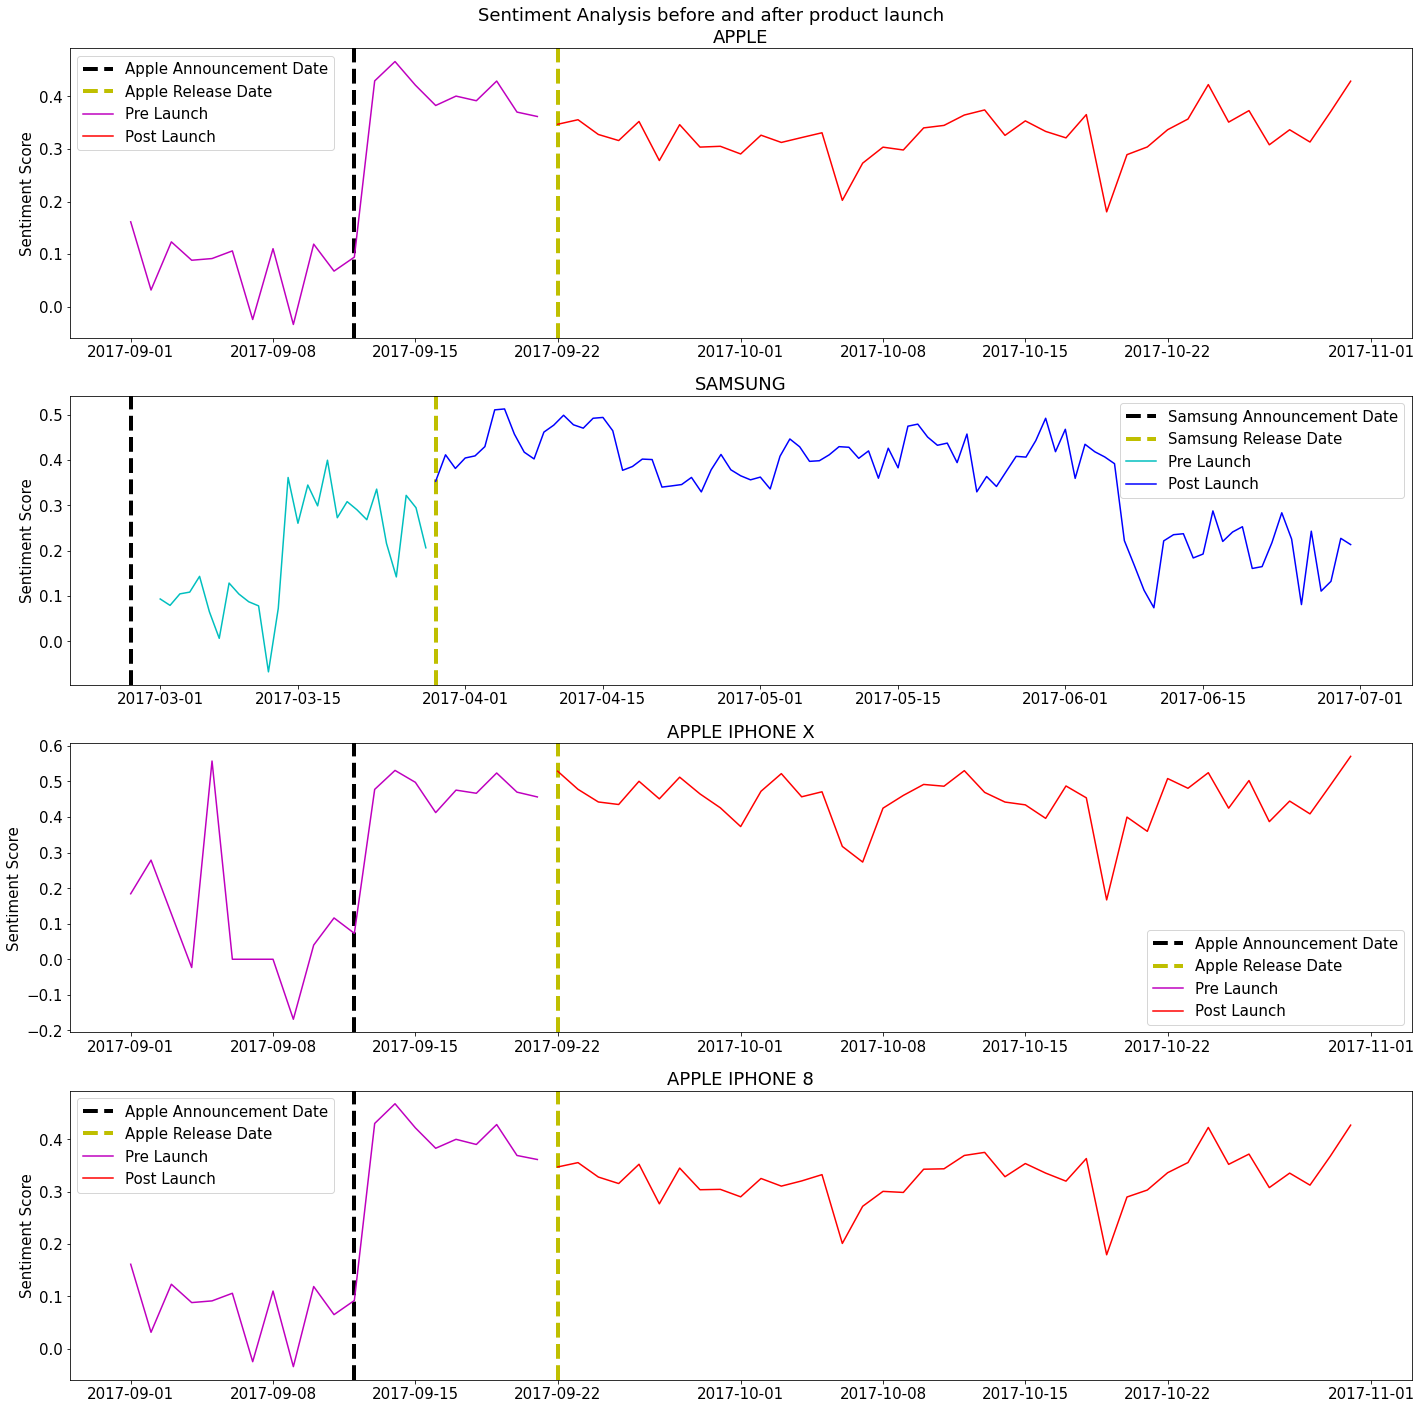

In [35]:
launch_df = product_launch_diff(data_dict)
display_launch_diff(launch_df)

In [36]:
def removeKeywords(text):
    text = text.lower()
    text = re.sub("(\w*(samsung)\w*)|(\w*(galaxy)\w*)|(\w*(s8)\w*)|(\w*(iphone)\w*)|(\w*(iphonex)\w*)|(\w*(iphone8)\w*)|(\w*(phone)\w*)|(\w*(apple)\w*)|(\w*(plus)\w*)|(\w*(iphone 8)\w*)|(\w*(iphone x)\w*)|", "", text)
    text = re.sub(r'#+', '#', text)
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\.+', '.', text)
    text = re.sub(r'\b\w{1,3}\b', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# https://www.geeksforgeeks.org/python-pos-tagging-and-lemmatization-using-spacy/
def processText(text):
    doc = nlp(text)
    word_tokenize = [token.lemma_ for token in list(doc) if ((token.is_stop==False) and len(token) > 2)]
    verbs = [token.text for token in doc if token.pos_ == "VERB"]
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    return {'verbs': verbs, 'nouns': nouns, 'adjectives': adjectives, 'word_tokenize': word_tokenize}

def createWordCloud(counter_df):
    d = {}
    for a, x in counter_df.values:
        d[a] = x

    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [37]:

for product, df in data_dict.items():
    if not os.path.isfile(product):
        df['clean_text']=df['Processed Sound Bite'].apply(lambda s: removeKeywords(s))
        df['processed_text'] = df['clean_text'].apply(lambda s: processText(s))
        df['word_tokenize'] = df['processed_text'].apply(lambda s: s['word_tokenize'])
        df['verbs'] = df['processed_text'].apply(lambda s: s['verbs'])
        df['nouns'] = df['processed_text'].apply(lambda s: s['nouns'])
        df['adjectives'] = df['processed_text'].apply(lambda s: s['adjectives'])
        df.to_csv(product)
    else:
        data_dict[product] = pd.read_csv(product, index_col=0)
        data_dict[product]['word_tokenize'] = data_dict[product]['word_tokenize'].apply(lambda s: ast.literal_eval(s))
        data_dict[product]['verbs'] = data_dict[product]['verbs'].apply(lambda s: ast.literal_eval(s))
        data_dict[product]['nouns'] = data_dict[product]['nouns'].apply(lambda s: ast.literal_eval(s))
        data_dict[product]['adjectives'] = data_dict[product]['adjectives'].apply(lambda s: ast.literal_eval(s))

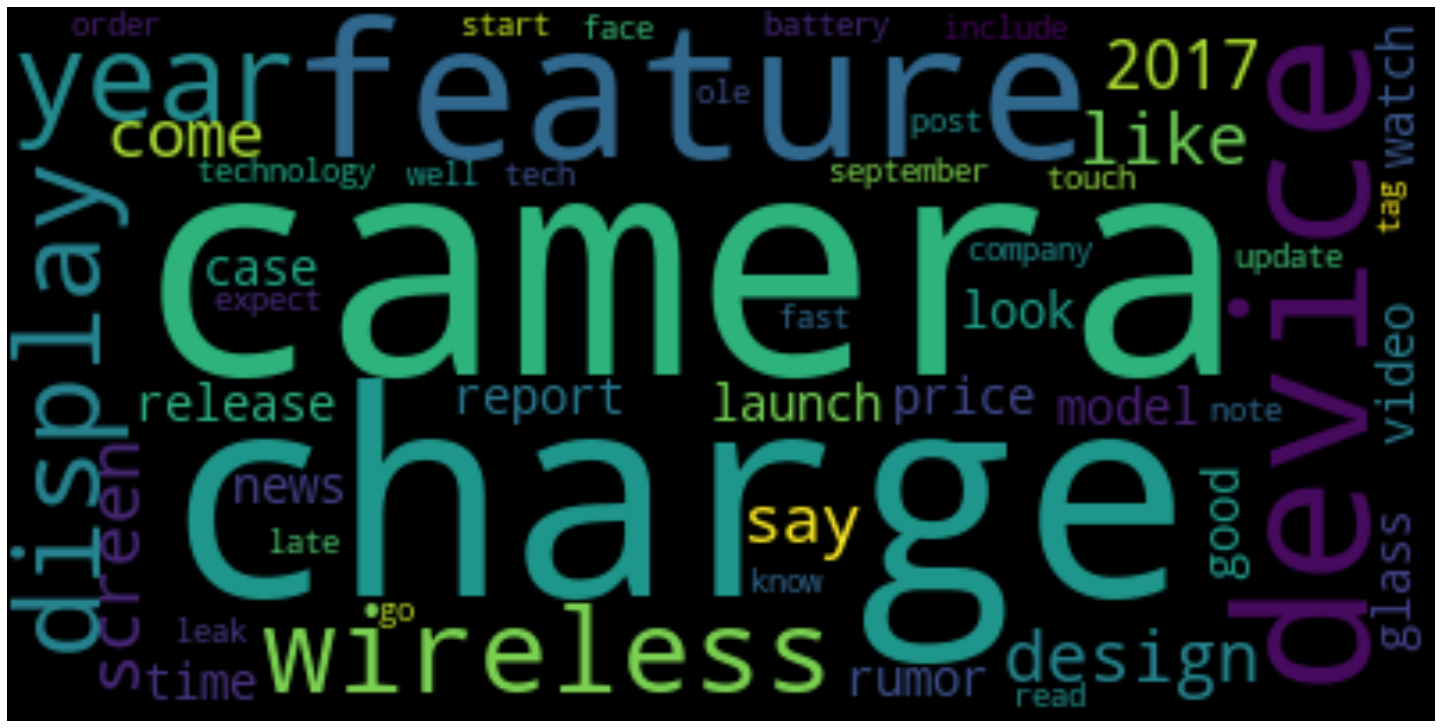

**********


Top ten keywords for Apple:
           0      1
1     camera  42957
2     charge  39920
3    feature  38904
4     device  36189
5       year  34694
6    display  32443
7   wireless  32129
8     design  31152
9       like  30961
10    screen  30025


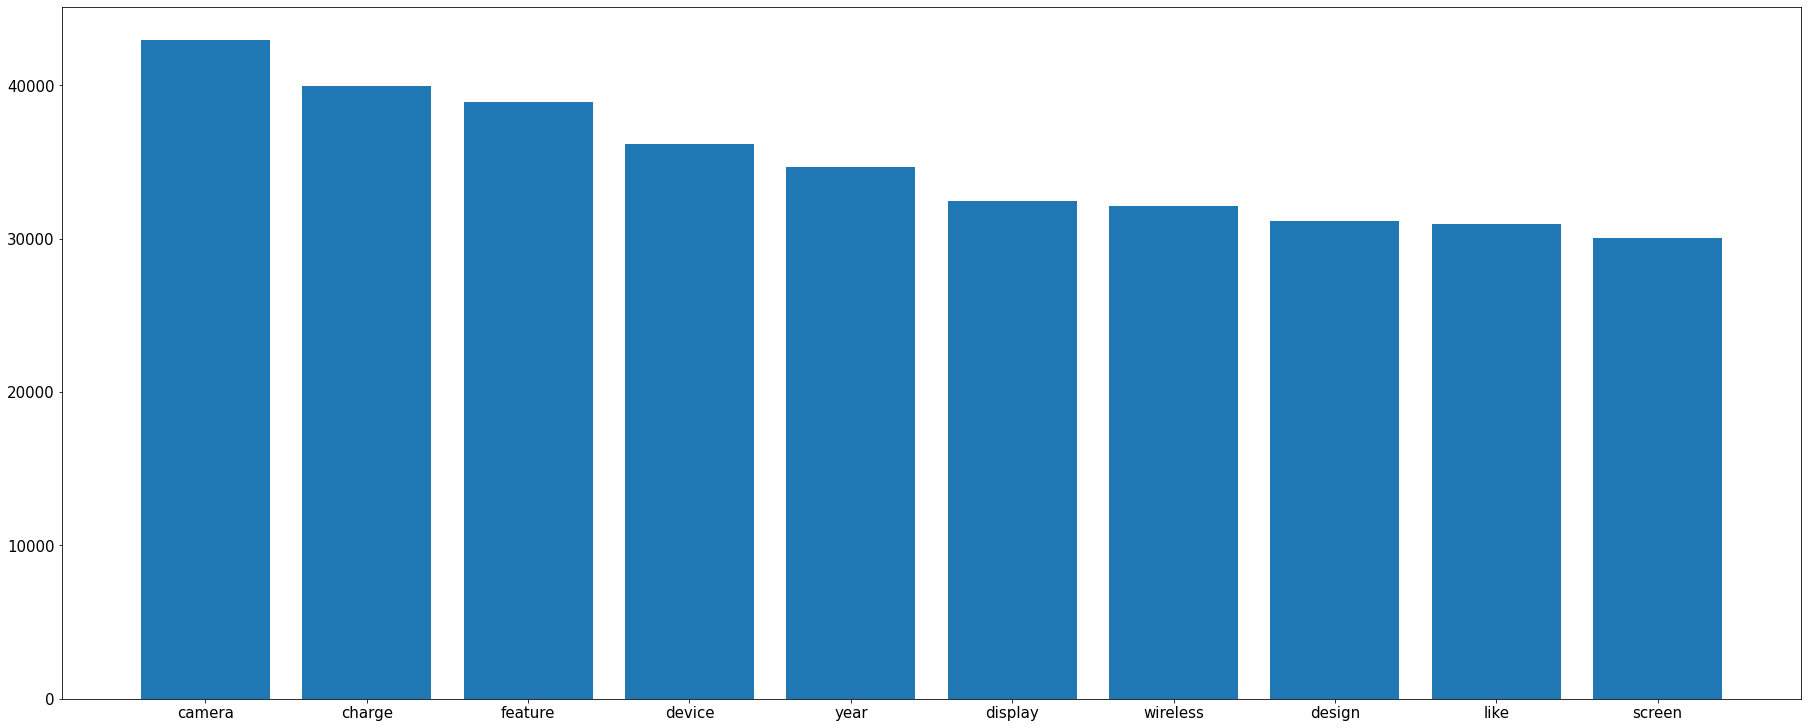

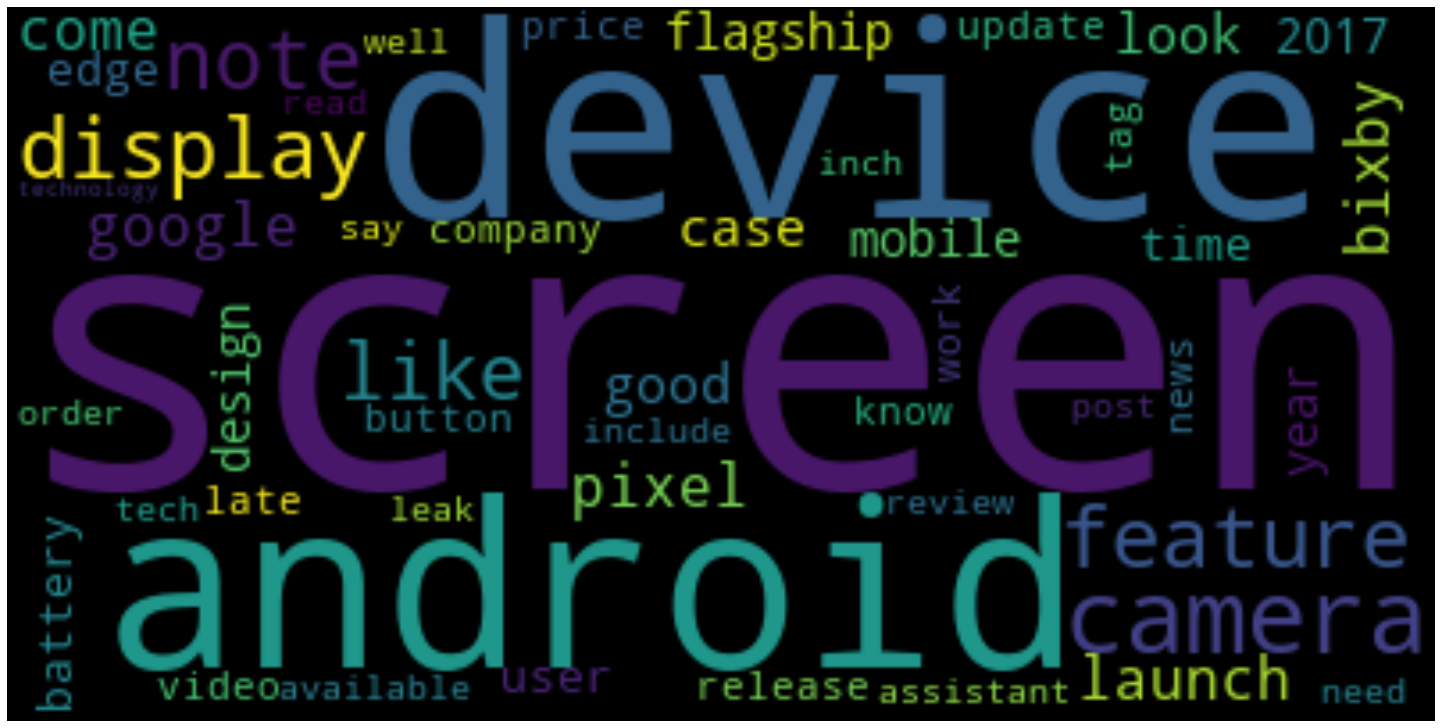

**********


Top ten keywords for Samsung:
          0      1
1    screen  58703
2    device  58553
3   android  56363
4    camera  52638
5   display  51085
6   feature  50283
7      note  46488
8      like  42725
9    google  40853
10   launch  39737


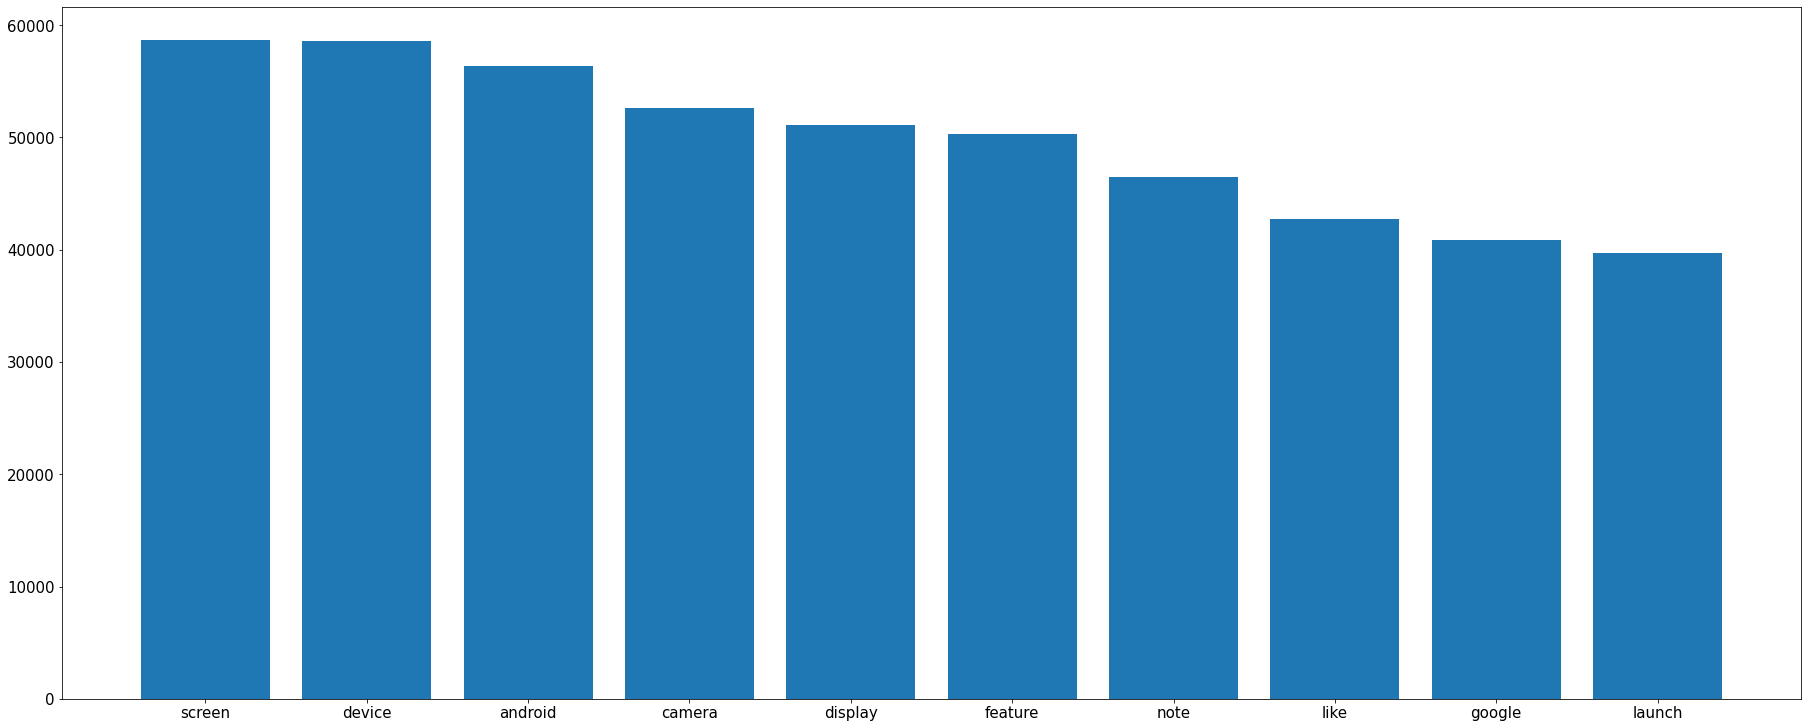

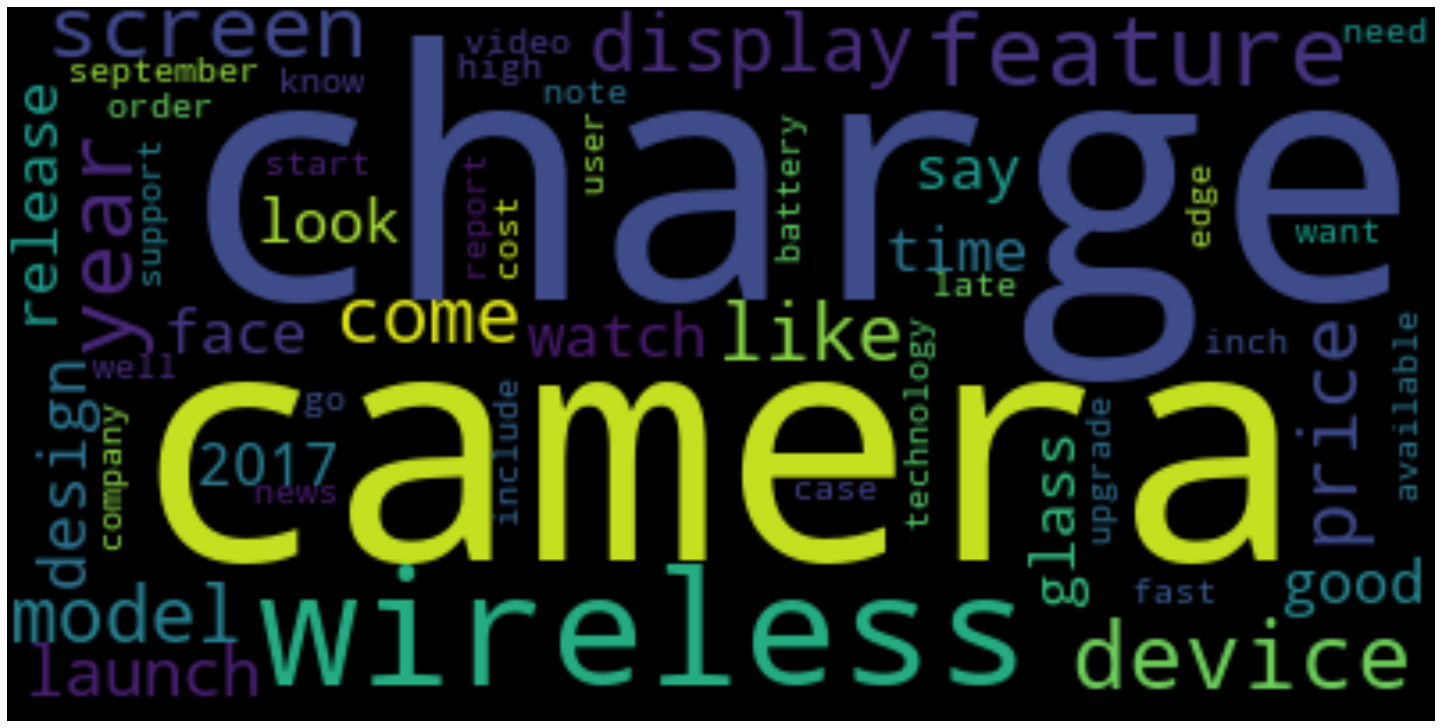

**********


Top ten keywords for Apple iPhone X:
           0      1
1     charge  22214
2     camera  19674
3   wireless  18282
4    feature  18280
5     device  15876
6       year  15360
7     screen  13592
8    display  13226
9      model  12827
10      come  12741


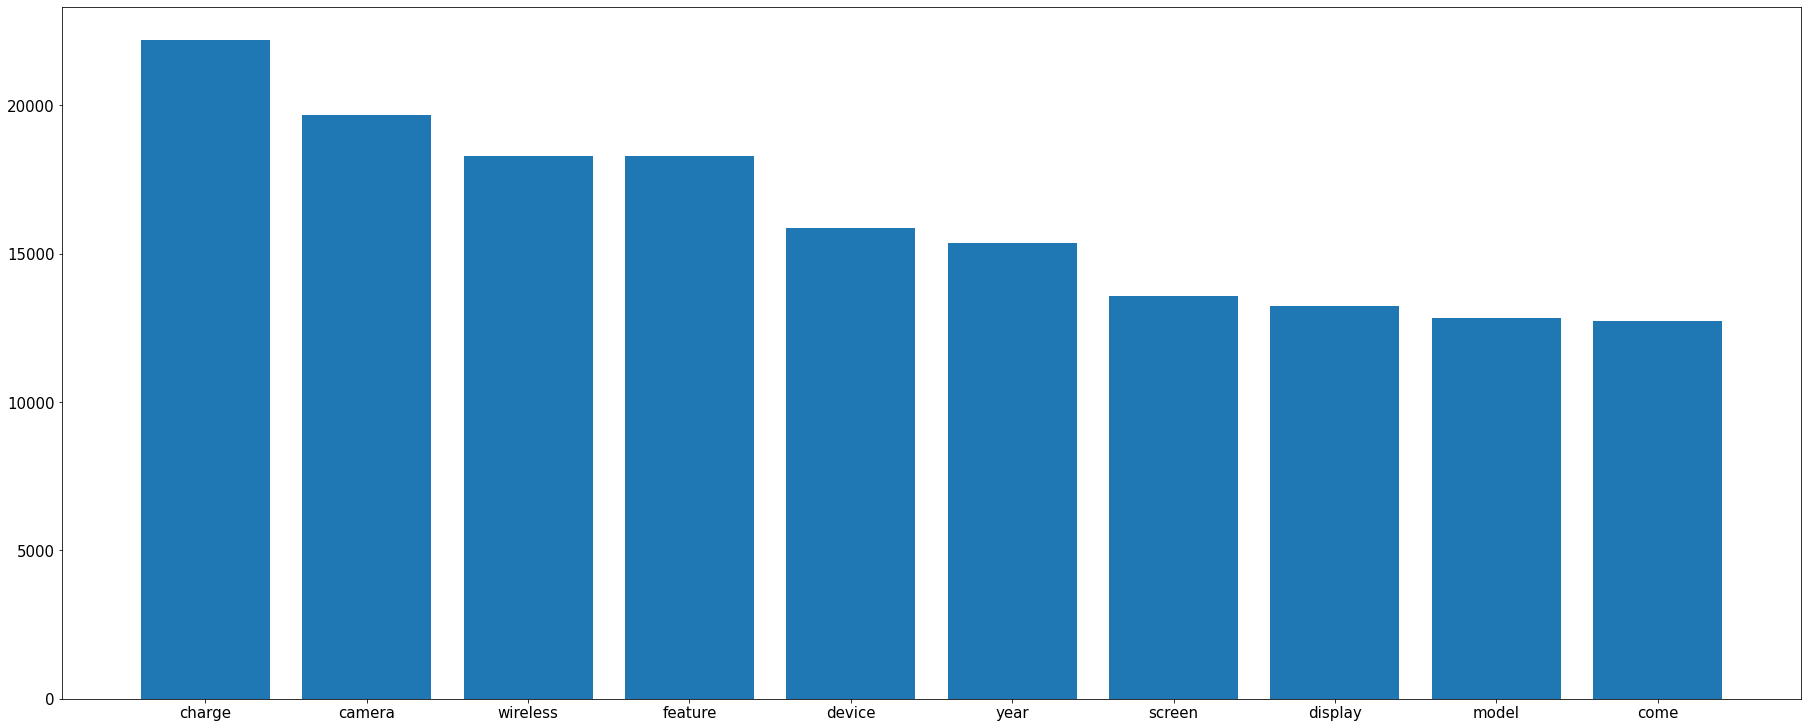

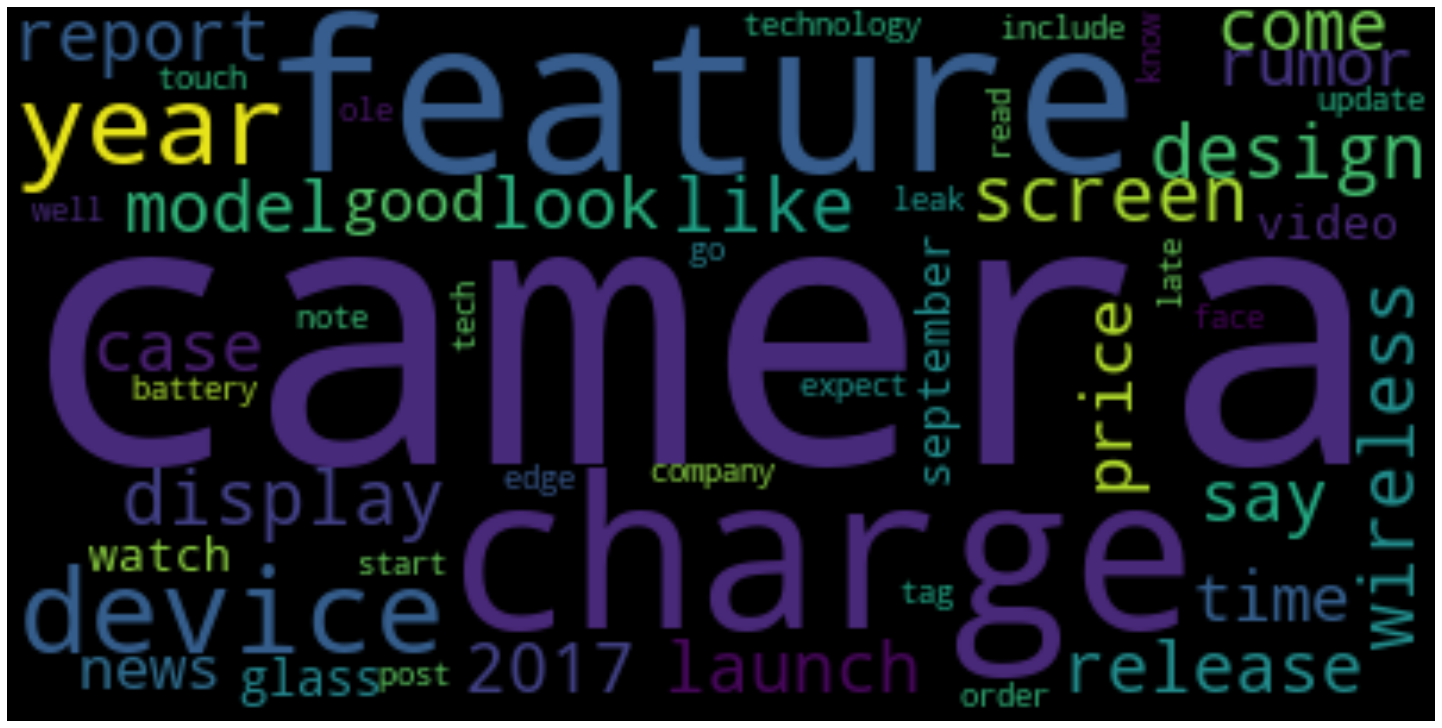

**********


Top ten keywords for Apple iPhone 8:
           0      1
1     camera  42671
2     charge  38643
3    feature  38377
4     device  35548
5       year  33813
6    display  31991
7   wireless  31289
8     design  30627
9       like  30259
10    screen  29622


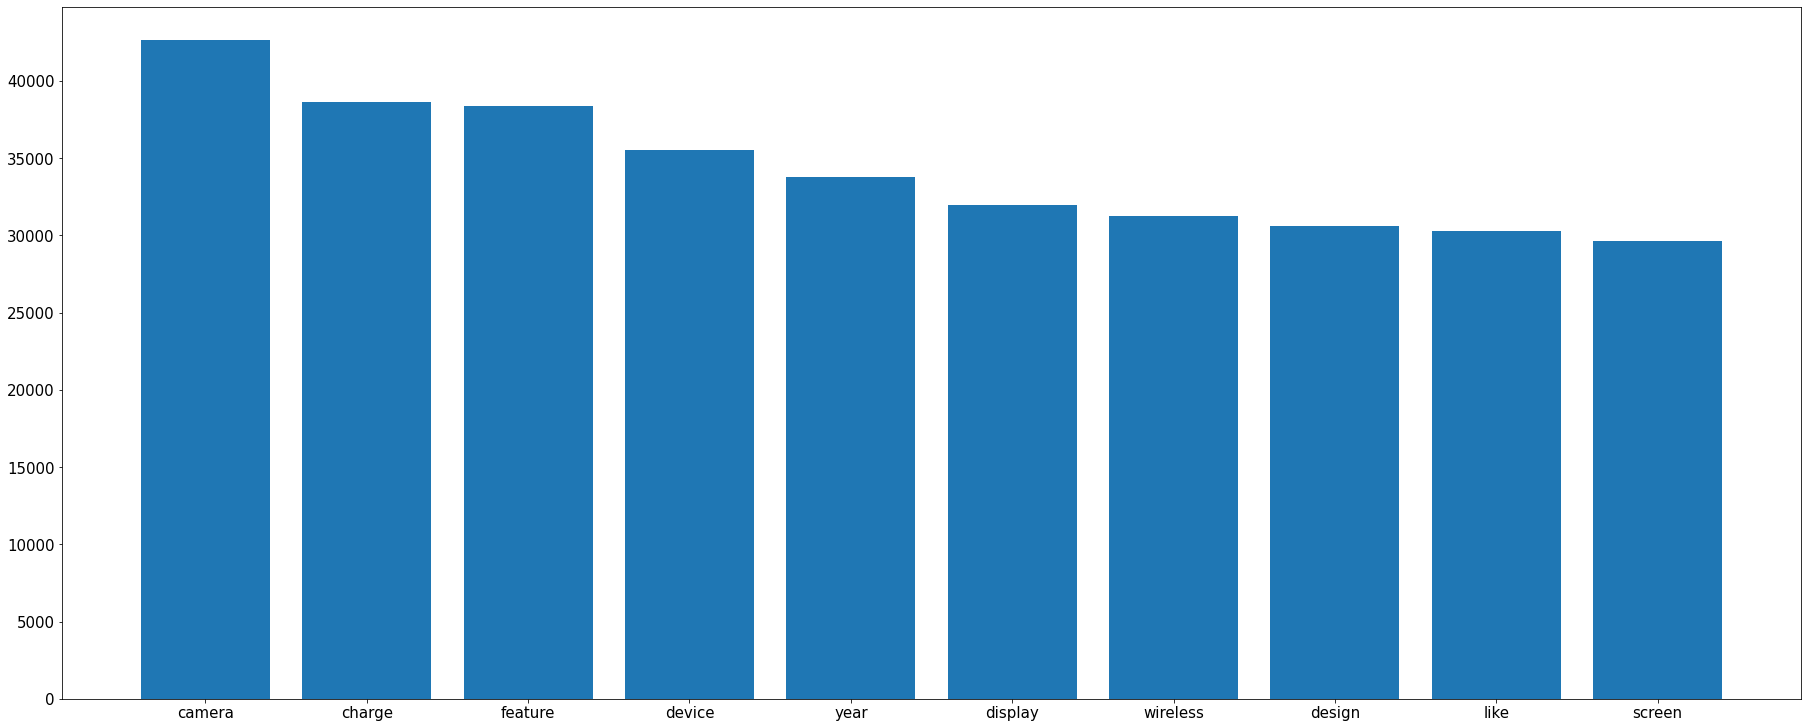

In [38]:
for name, df in data_dict.items():
    all_words_iter = list(itertools.chain(*df['word_tokenize'].tolist()))
    words_counter = collections.Counter(all_words_iter)
    counter_df = pd.DataFrame(words_counter.most_common(50))
    counter_df.index = counter_df.index + 1
    createWordCloud(counter_df)
    print("*"*10)
    print(f"\n\nTop ten keywords for {name}:")
    print(counter_df.head(10))
    plt.bar(counter_df.head(10)[0], counter_df.head(10)[1])
    plt.show()
    

**********


Top ten adjectives for Apple:
            0      1
1        more  26724
2       other  17732
3       first  15681
4        same  15220
5      latest  13596
6   available  13263
7    wireless  13199
8        best  11853
9        next  11561
10       last  11163


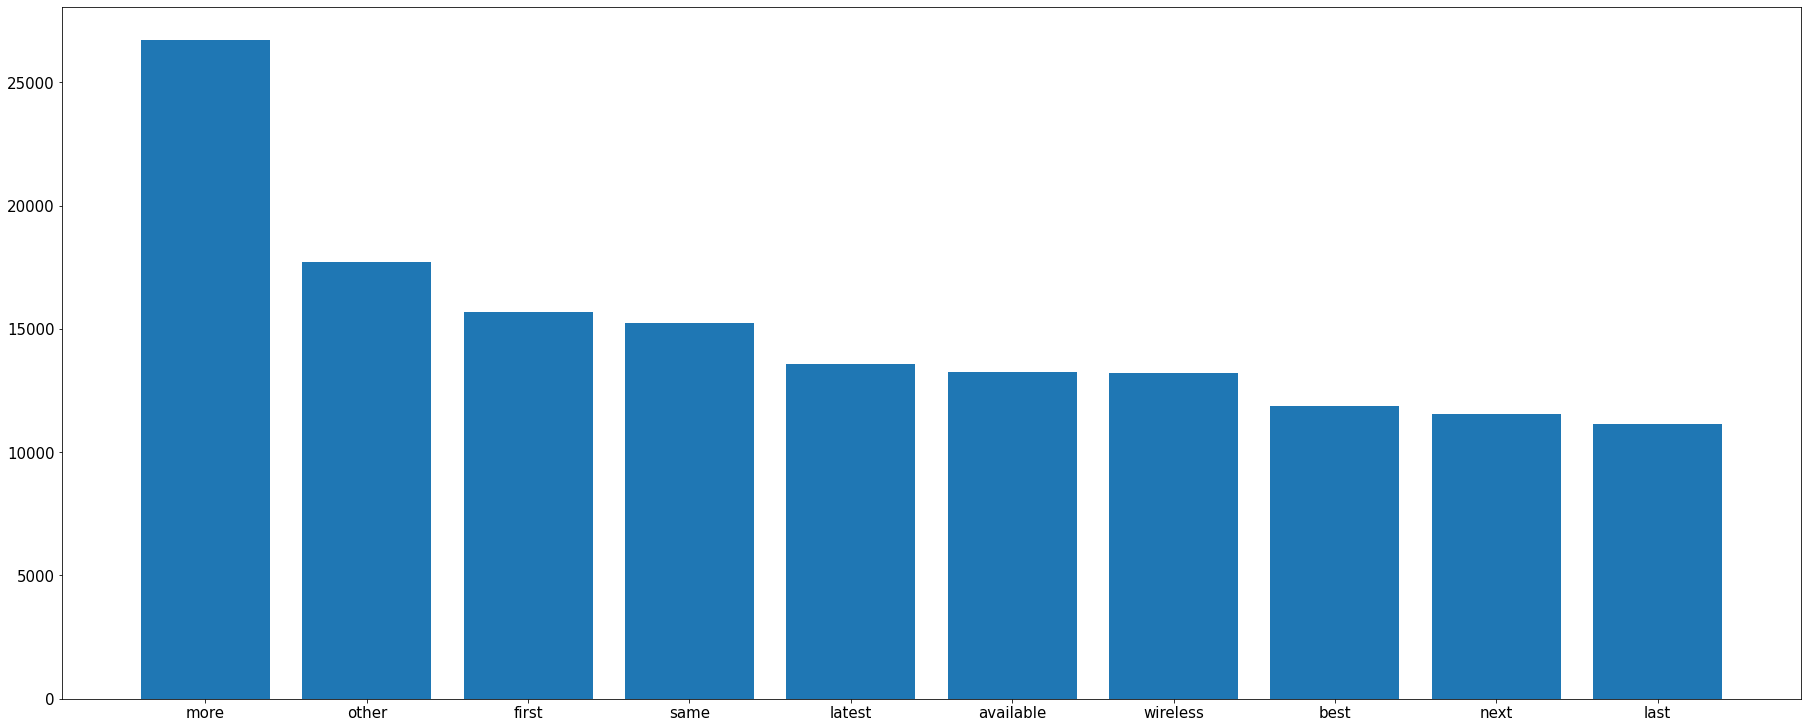

**********


Top ten adjectives for Samsung:
            0      1
1        more  30924
2       other  25957
3        best  20528
4      mobile  19729
5       first  19599
6   available  19005
7      latest  18515
8        same  17068
9        last  15987
10       full  14161


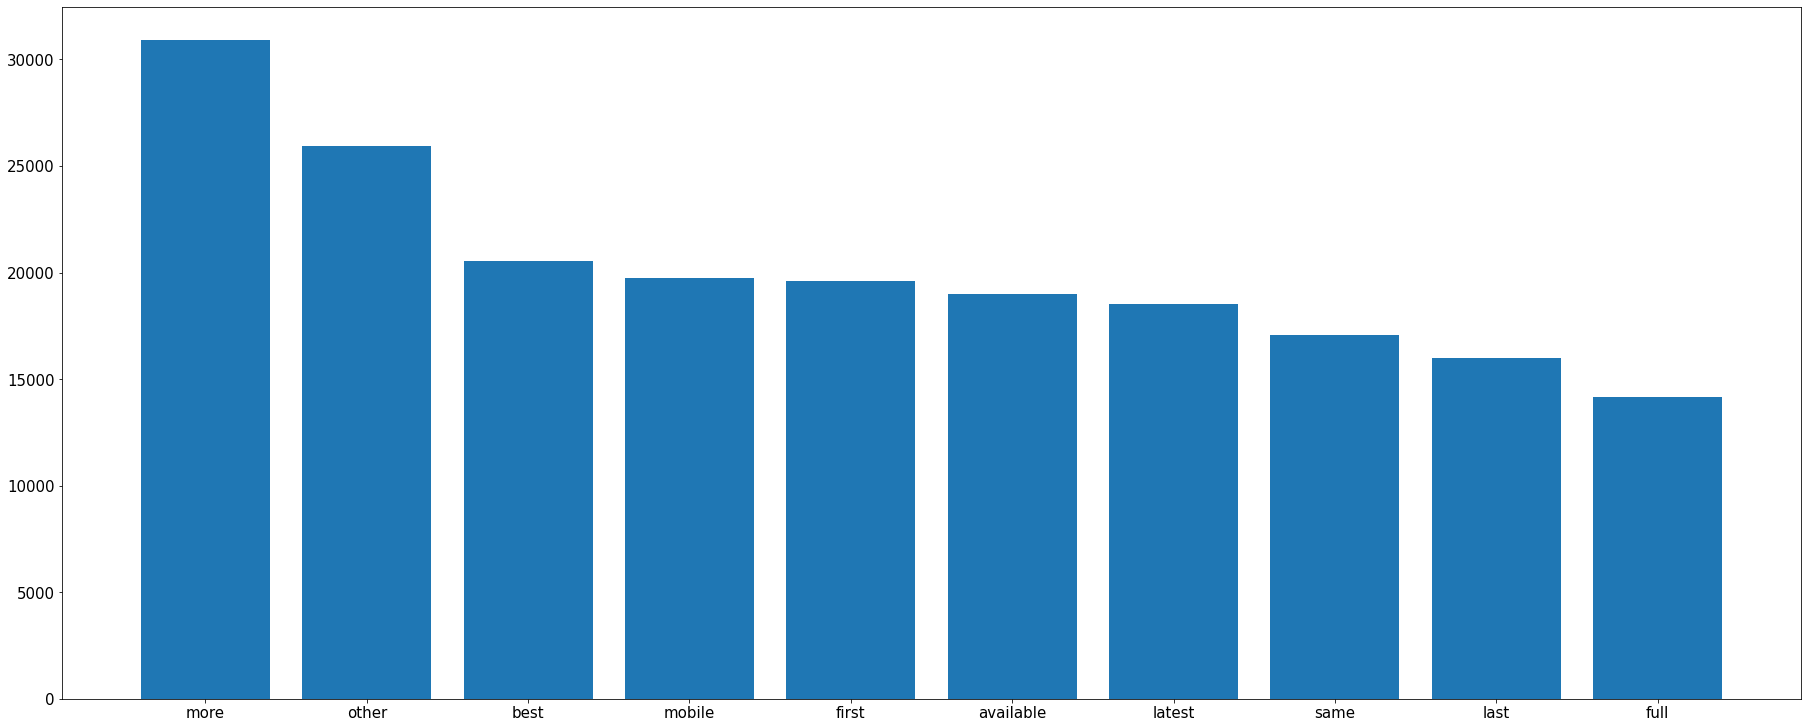

**********


Top ten adjectives for Apple iPhone X:
            0      1
1        more  11279
2        same   8307
3       other   8093
4    wireless   7642
5   available   7449
6       first   6783
7      latest   5351
8        last   5296
9        best   5258
10       many   4580


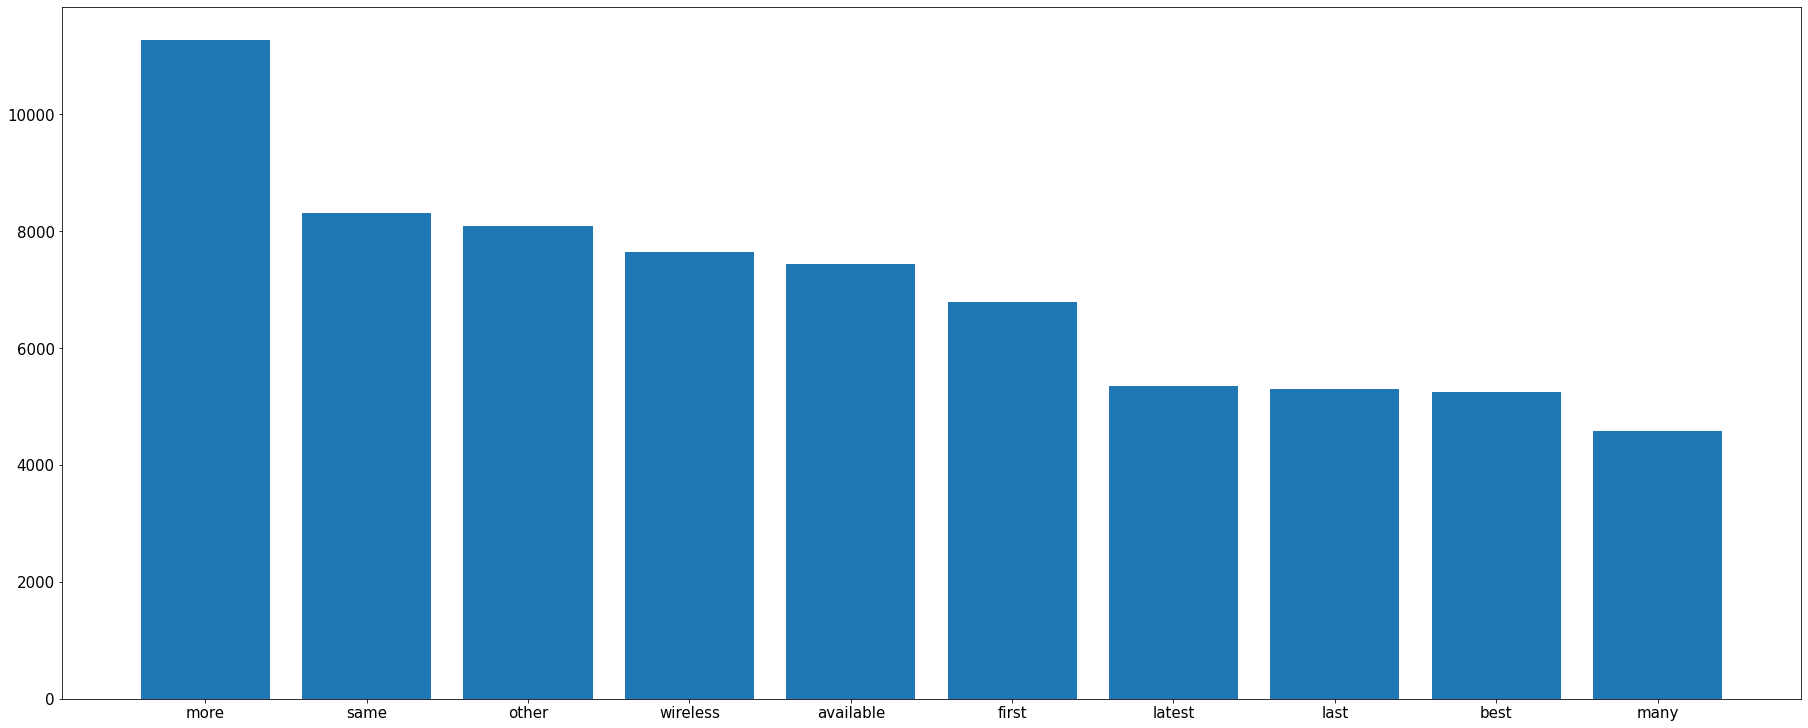

**********


Top ten adjectives for Apple iPhone 8:
            0      1
1        more  26208
2       other  17430
3       first  15193
4        same  15006
5      latest  13326
6   available  13111
7    wireless  12860
8        best  11628
9        next  11356
10       last  10883


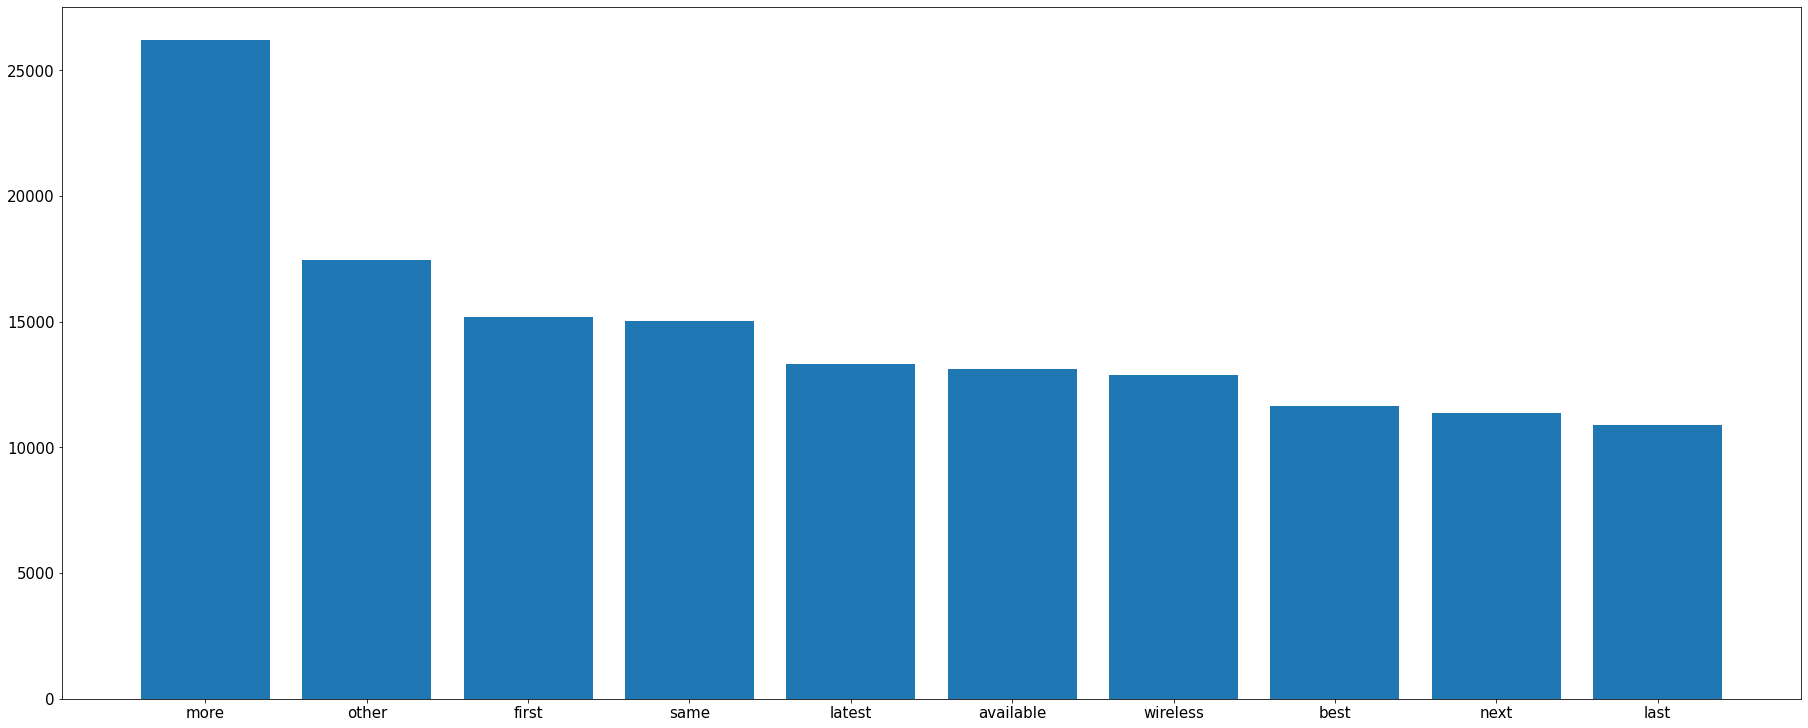

In [39]:
for name, df in data_dict.items():
    all_words_iter = list(itertools.chain(*df['adjectives'].tolist()))
    words_counter = collections.Counter(all_words_iter)
    counter_df = pd.DataFrame(words_counter.most_common(50))
    counter_df.index = counter_df.index + 1
    # createWordCloud(counter_df)
    print("*"*10)
    print(f"\n\nTop ten adjectives for {name}:")
    print(counter_df.head(10))
    plt.bar(counter_df.head(10)[0], counter_df.head(10)[1])
    plt.show()

In [40]:
def getSentimentType(score):
    if score < 0:
        return 'negative'
    if score == 0:
        return 'neutral'
    if score > 0:
        return 'positive'

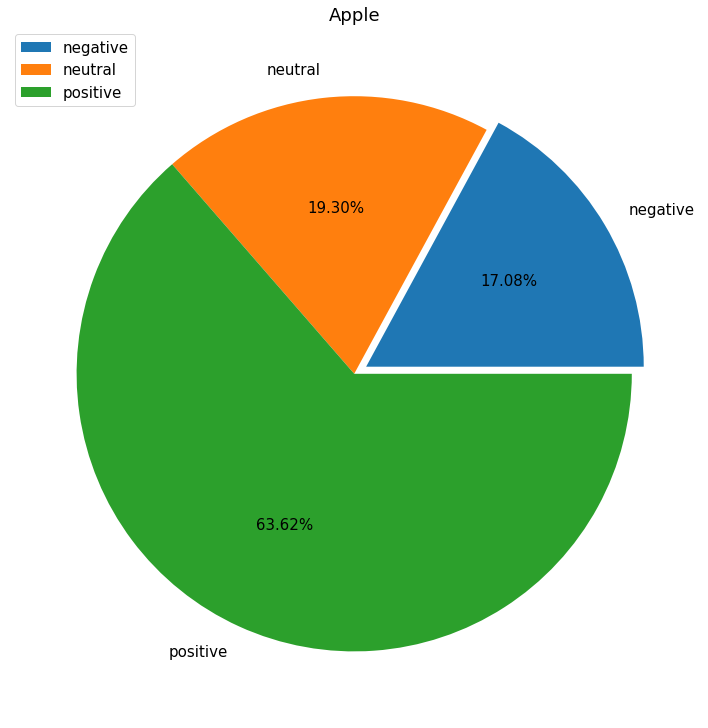

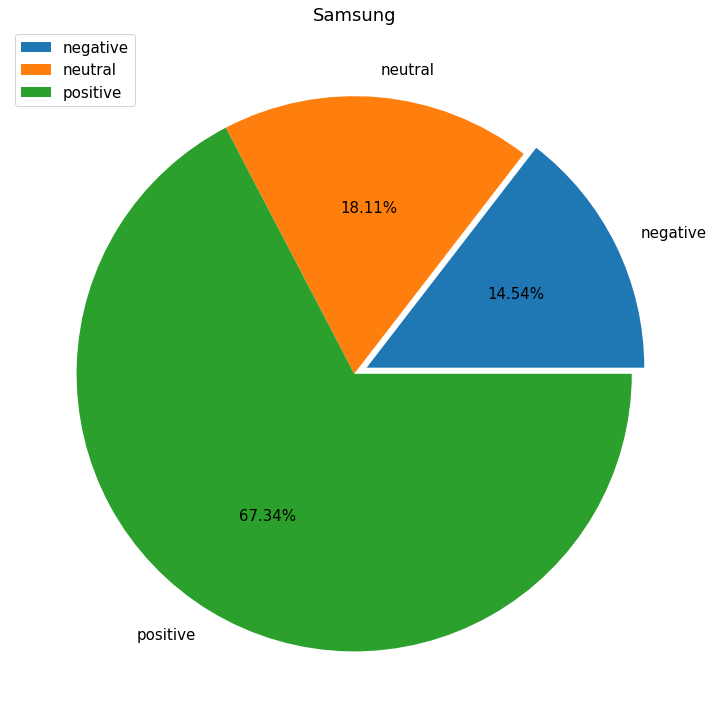

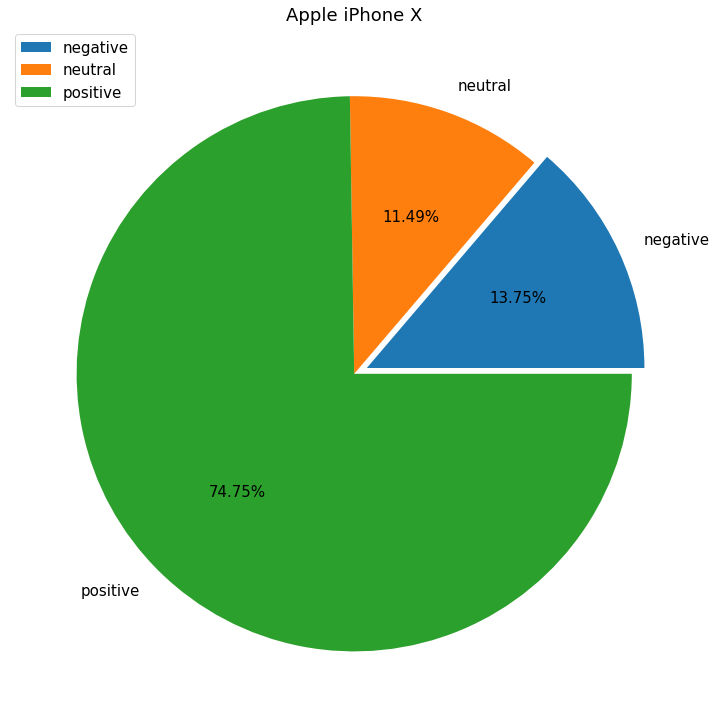

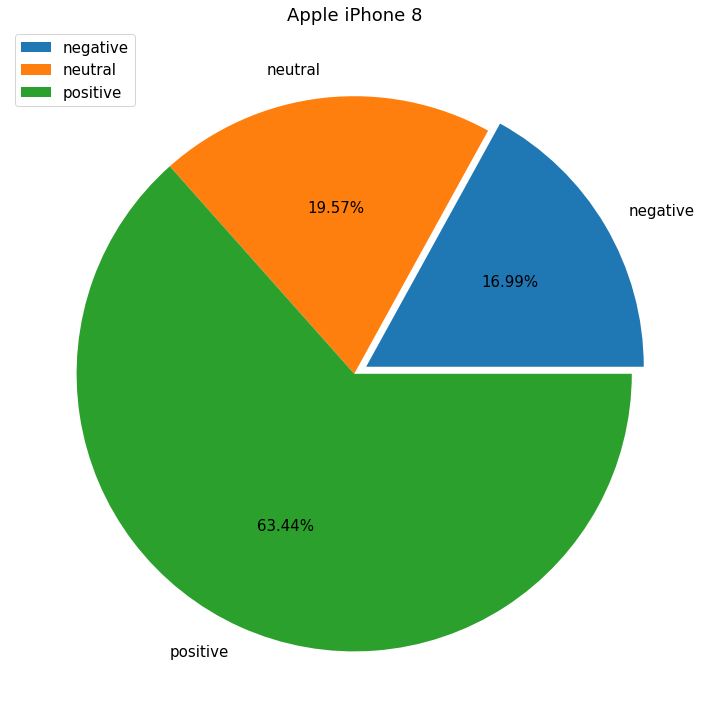

In [41]:
for name, df in data_dict.items():
    df['sentiment_type'] = df['sentiment_score'].apply(lambda s: getSentimentType(s))
    data_dict[name]['sentiment_type'] = data_dict[name]['sentiment_score'].apply(lambda s: getSentimentType(s))
    
    brand_sentiment_size = df.groupby('sentiment_type').size().reset_index()
    plt.rcParams["figure.figsize"] = (25,10)
    pd.set_option('display.max_rows', 4000)
    plt.rcParams['font.size'] = 15

    lbls = brand_sentiment_size['sentiment_type'].tolist()
    vals = np.array(brand_sentiment_size[0].tolist())
    plt.pie(vals, labels=lbls, explode = [0.05, 0, 0], autopct='%.2f%%')
    plt.title(name)
    plt.legend(loc='upper left')
    plt.show()

In [42]:
for name, df in data_dict.items():
    positive_sentiment = df[df['sentiment_type'] == 'positive']
    negative_sentiment = df[df['sentiment_type'] == 'negative']
    all_words_iter_pos = list(itertools.chain(*positive_sentiment['word_tokenize'].tolist()))
    all_words_iter_neg = list(itertools.chain(*negative_sentiment['word_tokenize'].tolist()))
    words_counter_pos = collections.Counter(all_words_iter_pos)
    words_counter_neg = collections.Counter(all_words_iter_neg)
    
    counter_df_pos = pd.DataFrame(words_counter_pos.most_common(50))
    counter_df_pos.index = counter_df_pos.index + 1
    # createWordCloud(counter_df)
    print("*"*10)
    print(f"\n\nTop ten keywords for {name} (Positive Sentiment):")
    print(counter_df_pos.head(10)[0])
    
    counter_df_neg = pd.DataFrame(words_counter_neg.most_common(50))
    counter_df_neg.index = counter_df_neg.index + 1
    # createWordCloud(counter_df)
    print("*"*10)
    print(f"\n\nTop ten keywords for {name} (Negative Sentiment):")
    print(counter_df_neg.head(10)[0])

**********


Top ten keywords for Apple (Positive Sentiment):
1       camera
2       charge
3      feature
4       device
5     wireless
6         year
7         like
8      display
9       design
10      screen
Name: 0, dtype: object
**********


Top ten keywords for Apple (Negative Sentiment):
1      report
2        leak
3      device
4         say
5        year
6      launch
7        news
8     release
9        2017
10     screen
Name: 0, dtype: object
**********


Top ten keywords for Samsung (Positive Sentiment):
1      device
2      screen
3      camera
4     android
5     display
6     feature
7        like
8        note
9      google
10       come
Name: 0, dtype: object
**********


Top ten keywords for Samsung (Negative Sentiment):
1        note
2        leak
3      device
4      screen
5     android
6     display
7      launch
8     problem
9       issue
10       user
Name: 0, dtype: object
**********


Top ten keywords for Apple iPhone X (Positive Sentiment):
1       charge


In [43]:
for name, df in data_dict.items():
    positive_sentiment = df[df['sentiment_type'] == 'positive']
    negative_sentiment = df[df['sentiment_type'] == 'negative']
    all_words_iter_pos = list(itertools.chain(*positive_sentiment['adjectives'].tolist()))
    all_words_iter_neg = list(itertools.chain(*negative_sentiment['adjectives'].tolist()))
    words_counter_pos = collections.Counter(all_words_iter_pos)
    words_counter_neg = collections.Counter(all_words_iter_neg)
    
    counter_df_pos = pd.DataFrame(words_counter_pos.most_common(50))
    counter_df_pos.index = counter_df_pos.index + 1
    # createWordCloud(counter_df)
    print("*"*10)
    print(f"\n\nTop ten adjectives for {name} (Positive Sentiment):")
    print(counter_df_pos.head(10)[0])
    
    counter_df_neg = pd.DataFrame(words_counter_neg.most_common(50))
    counter_df_neg.index = counter_df_neg.index + 1
    # createWordCloud(counter_df)
    print("*"*10)
    print(f"\n\nTop ten adjectives for {name} (Negative Sentiment):")
    print(counter_df_neg.head(10)[0])

**********


Top ten adjectives for Apple (Positive Sentiment):
1          more
2         other
3          same
4         first
5      wireless
6          best
7     available
8        latest
9          next
10         last
Name: 0, dtype: object
**********


Top ten adjectives for Apple (Negative Sentiment):
1           more
2          first
3          other
4         latest
5           same
6           last
7           next
8     irrelevant
9           many
10          open
Name: 0, dtype: object
**********


Top ten adjectives for Samsung (Positive Sentiment):
1          more
2         other
3          best
4     available
5        mobile
6         first
7        latest
8          same
9          last
10         good
Name: 0, dtype: object
**********


Top ten adjectives for Samsung (Negative Sentiment):
1       more
2      first
3      other
4       last
5     latest
6     mobile
7       same
8       many
9       next
10    korean
Name: 0, dtype: object
**********


Top ten adjecti

In [44]:
price_kw = ['price','expensive','amount','cheap', 'costly','exorbitant', 'overpriced','inexpensive',
           'low-price','affordable','bargain']
quality_kw = ['cheap','good','bad','great','degrade','upgrade','superior','inferior','satisfy','quality',
              'ease','helpful','convenience']
value_kw = ['worth', 'affordable','use','service','useful','utility','benefit','advantage','value']

In [45]:
def hasKeywords(text, keywords):
    if any(w in str(text) for w in keywords):
        return True
    else: 
        return False

prelaunch_price=[]
postlaunch_price=[]
prelaunch_quality=[]
postlaunch_quality=[]
prelaunch_value=[]
postlaunch_value=[]

for name, df in data_dict.items():    
    df['date'] = pd.to_datetime(df['date'], format='%Y %m %d')
    print(name)
    if 'apple' in name.lower():
        brand = 'apple'
    launch, start, end = launch_dates[brand], start_dates[brand], end_dates[brand]
    prelaunch_df = df[(df['date'] >= start) & (df['date'] < launch)]
    postlaunch_df = df[(df['date'] >= launch) & (df['date'] <= end)]
    
    prelaunch_df['Price'] = prelaunch_df['clean_text'].apply(lambda s: hasKeywords(s, price_kw))
    df_price = prelaunch_df[prelaunch_df['Price'] == True]
    
    print(f"Price Sentiment (Pre-Launch): {np.round(df_price['sentiment_score'].mean(),2)}")
    prelaunch_price.append(np.round(df_price['sentiment_score'].mean(),2))
    
    postlaunch_df['Price'] = postlaunch_df['clean_text'].apply(lambda s: hasKeywords(s, price_kw))
    df_price = postlaunch_df[postlaunch_df['Price'] == True]
    print(f"Price Sentiment (Post-Launch): {np.round(df_price['sentiment_score'].mean(),2)}")
    postlaunch_price.append(np.round(df_price['sentiment_score'].mean(),2))
    
    prelaunch_df['Quality'] = prelaunch_df['clean_text'].apply(lambda s: hasKeywords(s, quality_kw))
    df_quality = prelaunch_df[prelaunch_df['Quality'] == True]
    print(f"Quality Sentiment (Pre-Launch): {np.round(df_quality['sentiment_score'].mean(),2)}")
    prelaunch_quality.append(np.round(df_quality['sentiment_score'].mean(),2))
    
    postlaunch_df['Quality'] = postlaunch_df['clean_text'].apply(lambda s: hasKeywords(s, quality_kw))
    df_quality = postlaunch_df[postlaunch_df['Quality'] == True]
    print(f"Quality Sentiment (Post-Launch): {np.round(df_quality['sentiment_score'].mean(),2)}")
    postlaunch_quality.append(np.round(df_quality['sentiment_score'].mean(),2))
    
    prelaunch_df['Value'] = prelaunch_df['clean_text'].apply(lambda s: hasKeywords(s, value_kw))
    df_value = prelaunch_df[prelaunch_df['Value'] == True]
    print(f"Value Sentiment (Pre-Launch): {np.round(df_value['sentiment_score'].mean(),2)}")
    prelaunch_value.append(np.round(df_value['sentiment_score'].mean(),2))
    
    postlaunch_df['Value'] = postlaunch_df['clean_text'].apply(lambda s: hasKeywords(s, value_kw))
    df_value = postlaunch_df[postlaunch_df['Value'] == True]
    print(f"Value Sentiment (Post-Launch): {np.round(df_value['sentiment_score'].mean(),2)}")
    postlaunch_value.append(np.round(df_value['sentiment_score'].mean(),2))
    print()

Apple
Price Sentiment (Pre-Launch): 0.58
Price Sentiment (Post-Launch): 0.51
Quality Sentiment (Pre-Launch): 0.6
Quality Sentiment (Post-Launch): 0.53
Value Sentiment (Pre-Launch): 0.63
Value Sentiment (Post-Launch): 0.45

Samsung
Price Sentiment (Pre-Launch): 0.64
Price Sentiment (Post-Launch): 0.62
Quality Sentiment (Pre-Launch): 0.65
Quality Sentiment (Post-Launch): 0.66
Value Sentiment (Pre-Launch): 0.58
Value Sentiment (Post-Launch): 0.57

Apple iPhone X
Price Sentiment (Pre-Launch): 0.64
Price Sentiment (Post-Launch): 0.58
Quality Sentiment (Pre-Launch): 0.65
Quality Sentiment (Post-Launch): 0.61
Value Sentiment (Pre-Launch): 0.68
Value Sentiment (Post-Launch): 0.61

Apple iPhone 8
Price Sentiment (Pre-Launch): 0.58
Price Sentiment (Post-Launch): 0.51
Quality Sentiment (Pre-Launch): 0.6
Quality Sentiment (Post-Launch): 0.53
Value Sentiment (Pre-Launch): 0.63
Value Sentiment (Post-Launch): 0.45



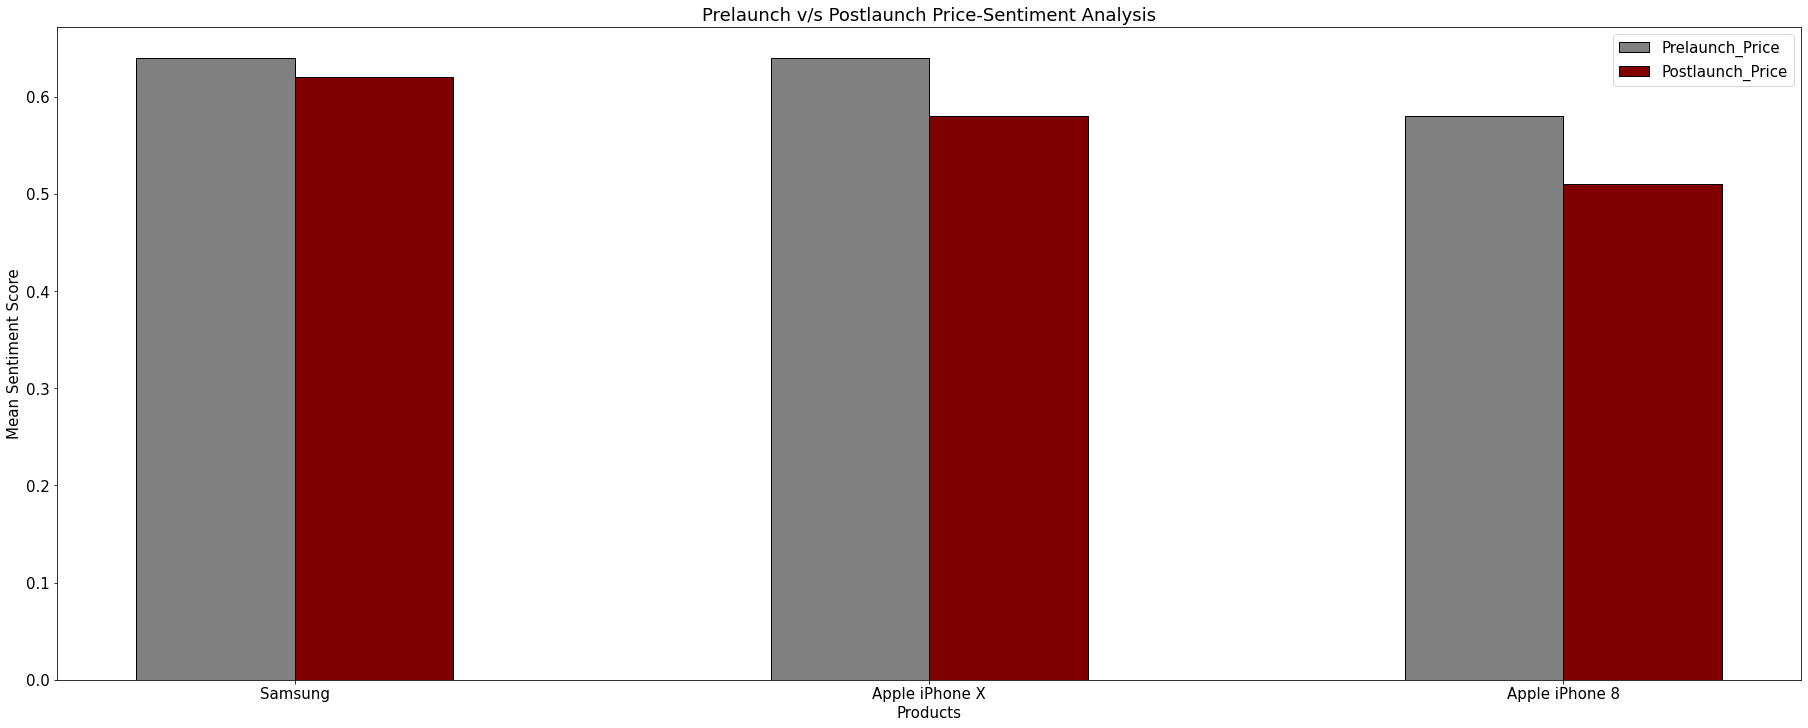

In [46]:
n = 3
r = np.arange(n)
width = 0.25

plt.bar(r, prelaunch_price[1:], color = 'grey',
        width = width, edgecolor = 'black',
        label='Prelaunch_Price')
plt.bar(r + width, postlaunch_price[1:], color = 'maroon',
        width = width, edgecolor = 'black',
        label='Postlaunch_Price')
  
plt.xlabel("Products")
plt.ylabel("Mean Sentiment Score")
plt.title("Prelaunch v/s Postlaunch Price-Sentiment Analysis")

plt.xticks(r + width/2, list(data_dict.keys())[1:])
plt.legend()
  
plt.show()

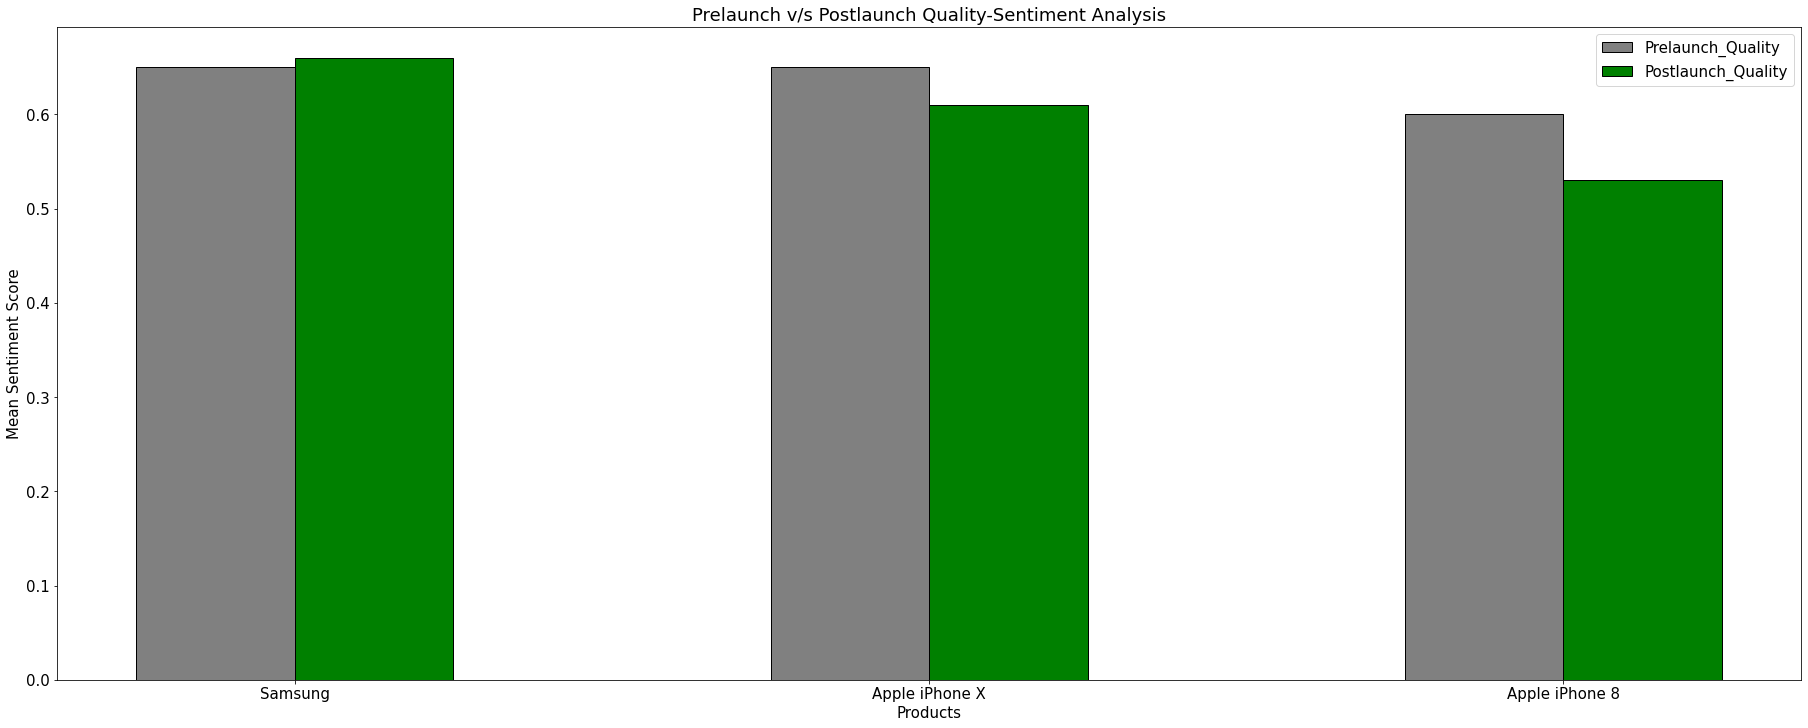

In [47]:
n = 3
r = np.arange(n)
width = 0.25

plt.bar(r, prelaunch_quality[1:], color = 'grey',
        width = width, edgecolor = 'black',
        label='Prelaunch_Quality')
plt.bar(r + width, postlaunch_quality[1:], color = 'green',
        width = width, edgecolor = 'black',
        label='Postlaunch_Quality')
  
plt.xlabel("Products")
plt.ylabel("Mean Sentiment Score")
plt.title("Prelaunch v/s Postlaunch Quality-Sentiment Analysis")

plt.xticks(r + width/2, list(data_dict.keys())[1:])
plt.legend()
  
plt.show()

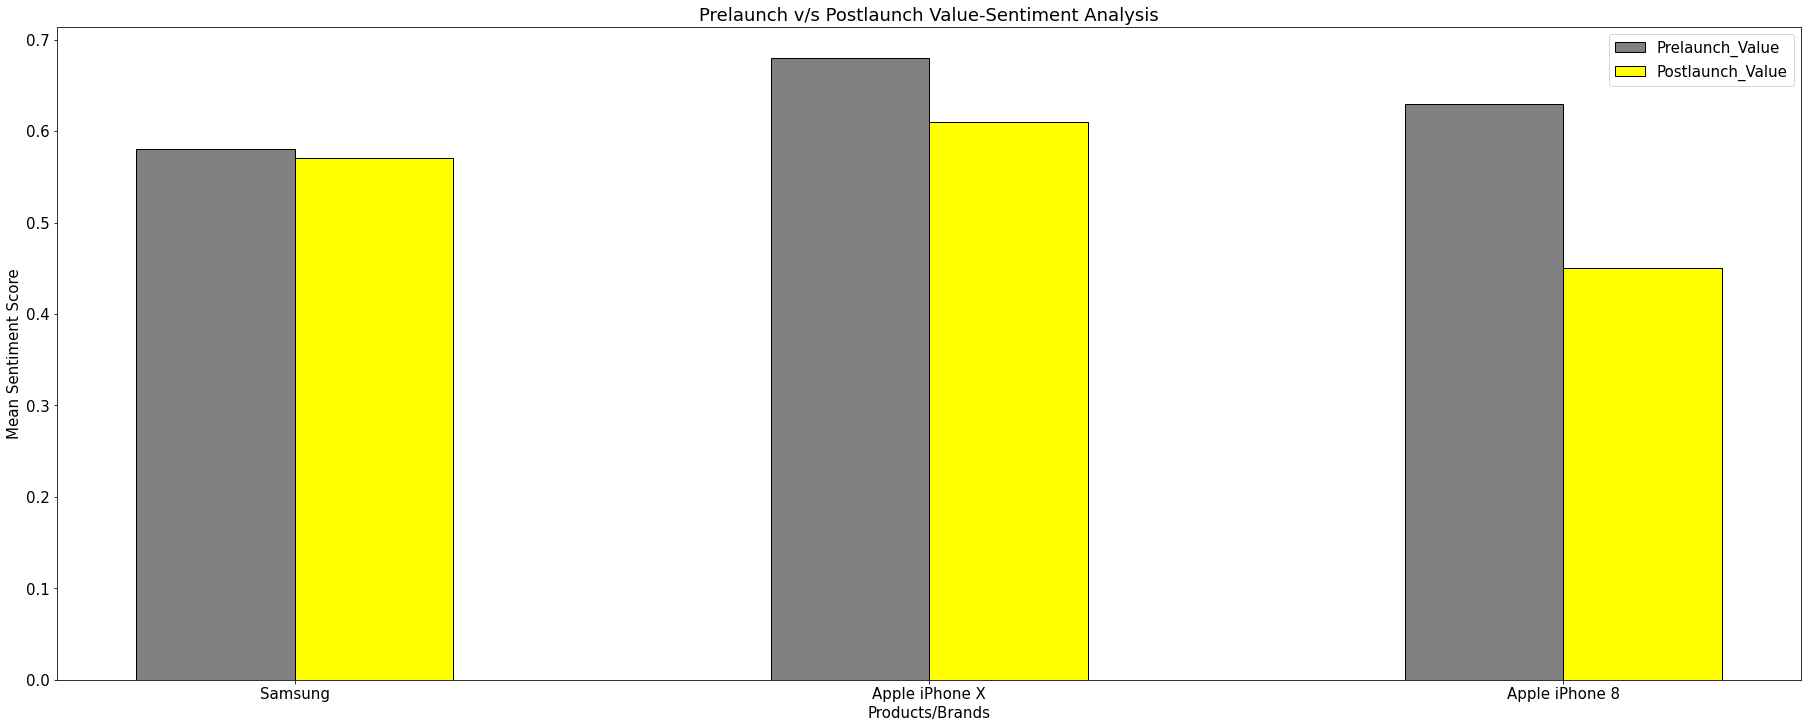

In [48]:
n = 3
r = np.arange(n)
width = 0.25

plt.bar(r, prelaunch_value[1:], color = 'grey',
        width = width, edgecolor = 'black',
        label='Prelaunch_Value')
plt.bar(r + width, postlaunch_value[1:], color = 'yellow',
        width = width, edgecolor = 'black',
        label='Postlaunch_Value')
  
plt.xlabel("Products/Brands")
plt.ylabel("Mean Sentiment Score")
plt.title("Prelaunch v/s Postlaunch Value-Sentiment Analysis")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2, list(data_dict.keys())[1:])
plt.legend()
  
plt.show()

### Extra Credit

In [49]:
Prelaunch_Twitter = []
Postlaunch_Twitter = []
Prelaunch_NonTwitter = []
Postlaunch_NonTwitter = []

for name, df in data_dict.items(): 
    df['date'] = pd.to_datetime(df['date'], format='%Y %m %d')
    
    df_twitter = df[df['Source Type'] == 'Twitter']
    df_nontwitter = df[df['Source Type'] != 'Twitter']

    print(name)
    if 'apple' in brand.lower():
        brand = 'apple'
    launch, start, end = launch_dates[brand], start_dates[brand], end_dates[brand]
    prelaunch_twitter_df = df_twitter[(df_twitter['date'] >= start) & (df_twitter['date'] < launch)]
    postlaunch_twitter_df = df_twitter[(df_twitter['date'] >= launch) & (df_twitter['date'] <= end)]
    
    prelaunch_nonTwitter_df = df_nontwitter[(df_nontwitter['date'] >= start) & (df_nontwitter['date'] < launch)]
    postlaunch_nonTwitter_df = df_nontwitter[(df_nontwitter['date'] >= launch) & (df_nontwitter['date'] <= end)]

    print('\tPre_launch sentiment for %s is %s' %('Twitter', np.round(prelaunch_twitter_df['sentiment_score'].mean(), 2)))
    print('\tPre_launch sentiment for %s is %s' %('Non-Twitter', np.round(prelaunch_nonTwitter_df['sentiment_score'].mean(), 2)))
    print("\t*")
    print('\tPost_launch sentiment for %s is %s' %('Twitter', np.round(postlaunch_twitter_df['sentiment_score'].mean(), 2)))
    print('\tPost_launch sentiment for %s is %s' %('Non-Twitter', np.round(postlaunch_nonTwitter_df['sentiment_score'].mean(), 2)))

    
    Prelaunch_Twitter.append(np.round(prelaunch_twitter_df['sentiment_score'].mean(),2))
    Prelaunch_NonTwitter.append(np.round(prelaunch_nonTwitter_df['sentiment_score'].mean(),2))
    Postlaunch_Twitter.append(np.round(postlaunch_twitter_df['sentiment_score'].mean(),2))
    Postlaunch_NonTwitter.append(np.round(postlaunch_nonTwitter_df['sentiment_score'].mean(),2))                   
    
    print()

Apple
	Pre_launch sentiment for Twitter is 0.1
	Pre_launch sentiment for Non-Twitter is 0.43
	*
	Post_launch sentiment for Twitter is 0.13
	Post_launch sentiment for Non-Twitter is 0.33

Samsung
	Pre_launch sentiment for Twitter is 0.17
	Pre_launch sentiment for Non-Twitter is 0.43
	*
	Post_launch sentiment for Twitter is 0.16
	Post_launch sentiment for Non-Twitter is 0.43

Apple iPhone X
	Pre_launch sentiment for Twitter is 0.12
	Pre_launch sentiment for Non-Twitter is 0.49
	*
	Post_launch sentiment for Twitter is 0.15
	Post_launch sentiment for Non-Twitter is 0.46

Apple iPhone 8
	Pre_launch sentiment for Twitter is 0.1
	Pre_launch sentiment for Non-Twitter is 0.43
	*
	Post_launch sentiment for Twitter is 0.13
	Post_launch sentiment for Non-Twitter is 0.33



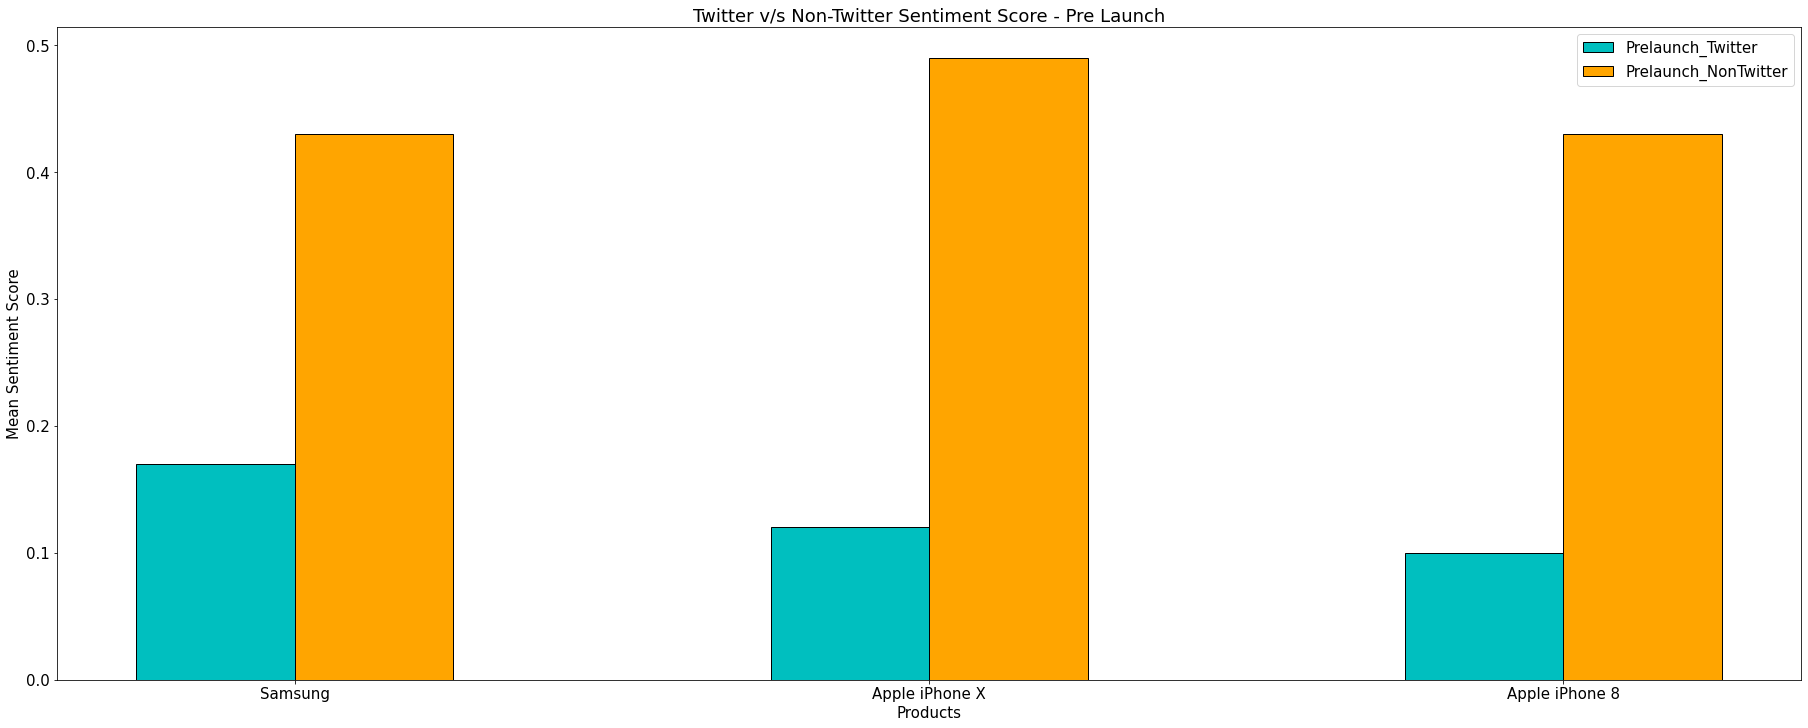

In [50]:
n = 3
r = np.arange(n)
width = 0.25
  
plt.bar(r, Prelaunch_Twitter[1:], color = 'c',
        width = width, edgecolor = 'black',
        label='Prelaunch_Twitter')
plt.bar(r + width, Prelaunch_NonTwitter[1:], color = 'orange',
        width = width, edgecolor = 'black',
        label='Prelaunch_NonTwitter')
  
plt.xlabel("Products")
plt.ylabel("Mean Sentiment Score")
plt.title("Twitter v/s Non-Twitter Sentiment Score - Pre Launch")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2, list(data_dict.keys())[1:])
plt.legend()
  
plt.show()

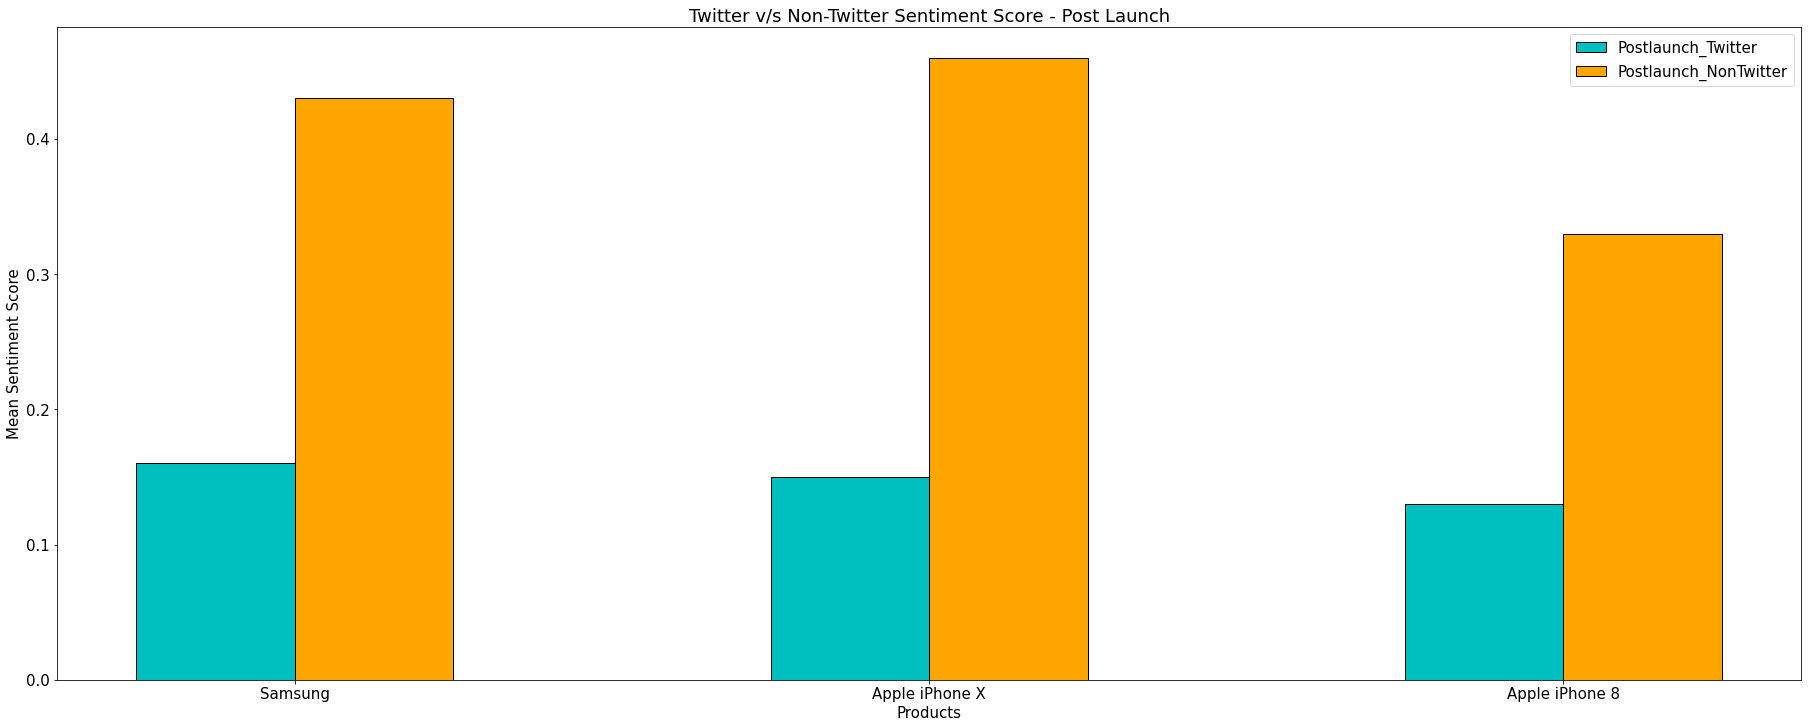

In [51]:
n = 3
r = np.arange(n)
width = 0.25
  
plt.bar(r, Postlaunch_Twitter[1:], color = 'c',
        width = width, edgecolor = 'black',
        label='Postlaunch_Twitter')
plt.bar(r + width, Postlaunch_NonTwitter[1:], color = 'orange',
        width = width, edgecolor = 'black',
        label='Postlaunch_NonTwitter')
  
plt.xlabel("Products")
plt.ylabel("Mean Sentiment Score")
plt.title("Twitter v/s Non-Twitter Sentiment Score - Post Launch")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2, list(data_dict.keys())[1:])
plt.legend()
  
plt.show()

## Topic Modeling for top keywords

In [52]:
import copy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import pyLDAvis.gensim_models


data_dict_2 = copy.deepcopy(data_dict)

#### Samsung S8

In [53]:
tpm_lda_df = data_dict_2['Samsung']
# Create a id2word dictionary
id2word = corpora.Dictionary(tpm_lda_df['word_tokenize'])
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
corpus = [id2word.doc2bow(d) for d in tpm_lda_df['word_tokenize']]
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=7)

# Filtering for words 
tpm_words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
tpm_topics = [' '.join(t[0:10]) for t in tpm_words]

for _id, t in enumerate(tpm_topics): 
    print(f"------ Topic {_id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
case bixby screen assistant button voice protector cover feature protection

------ Topic 1 ------
launch device flagship note company release come feature year leak

------ Topic 2 ------
camera display screen pixel feature battery good like design look

------ Topic 3 ------
tag android news tech twitter 2017 google review ifttt technology

------ Topic 4 ------
android device update mobile download work google user like app



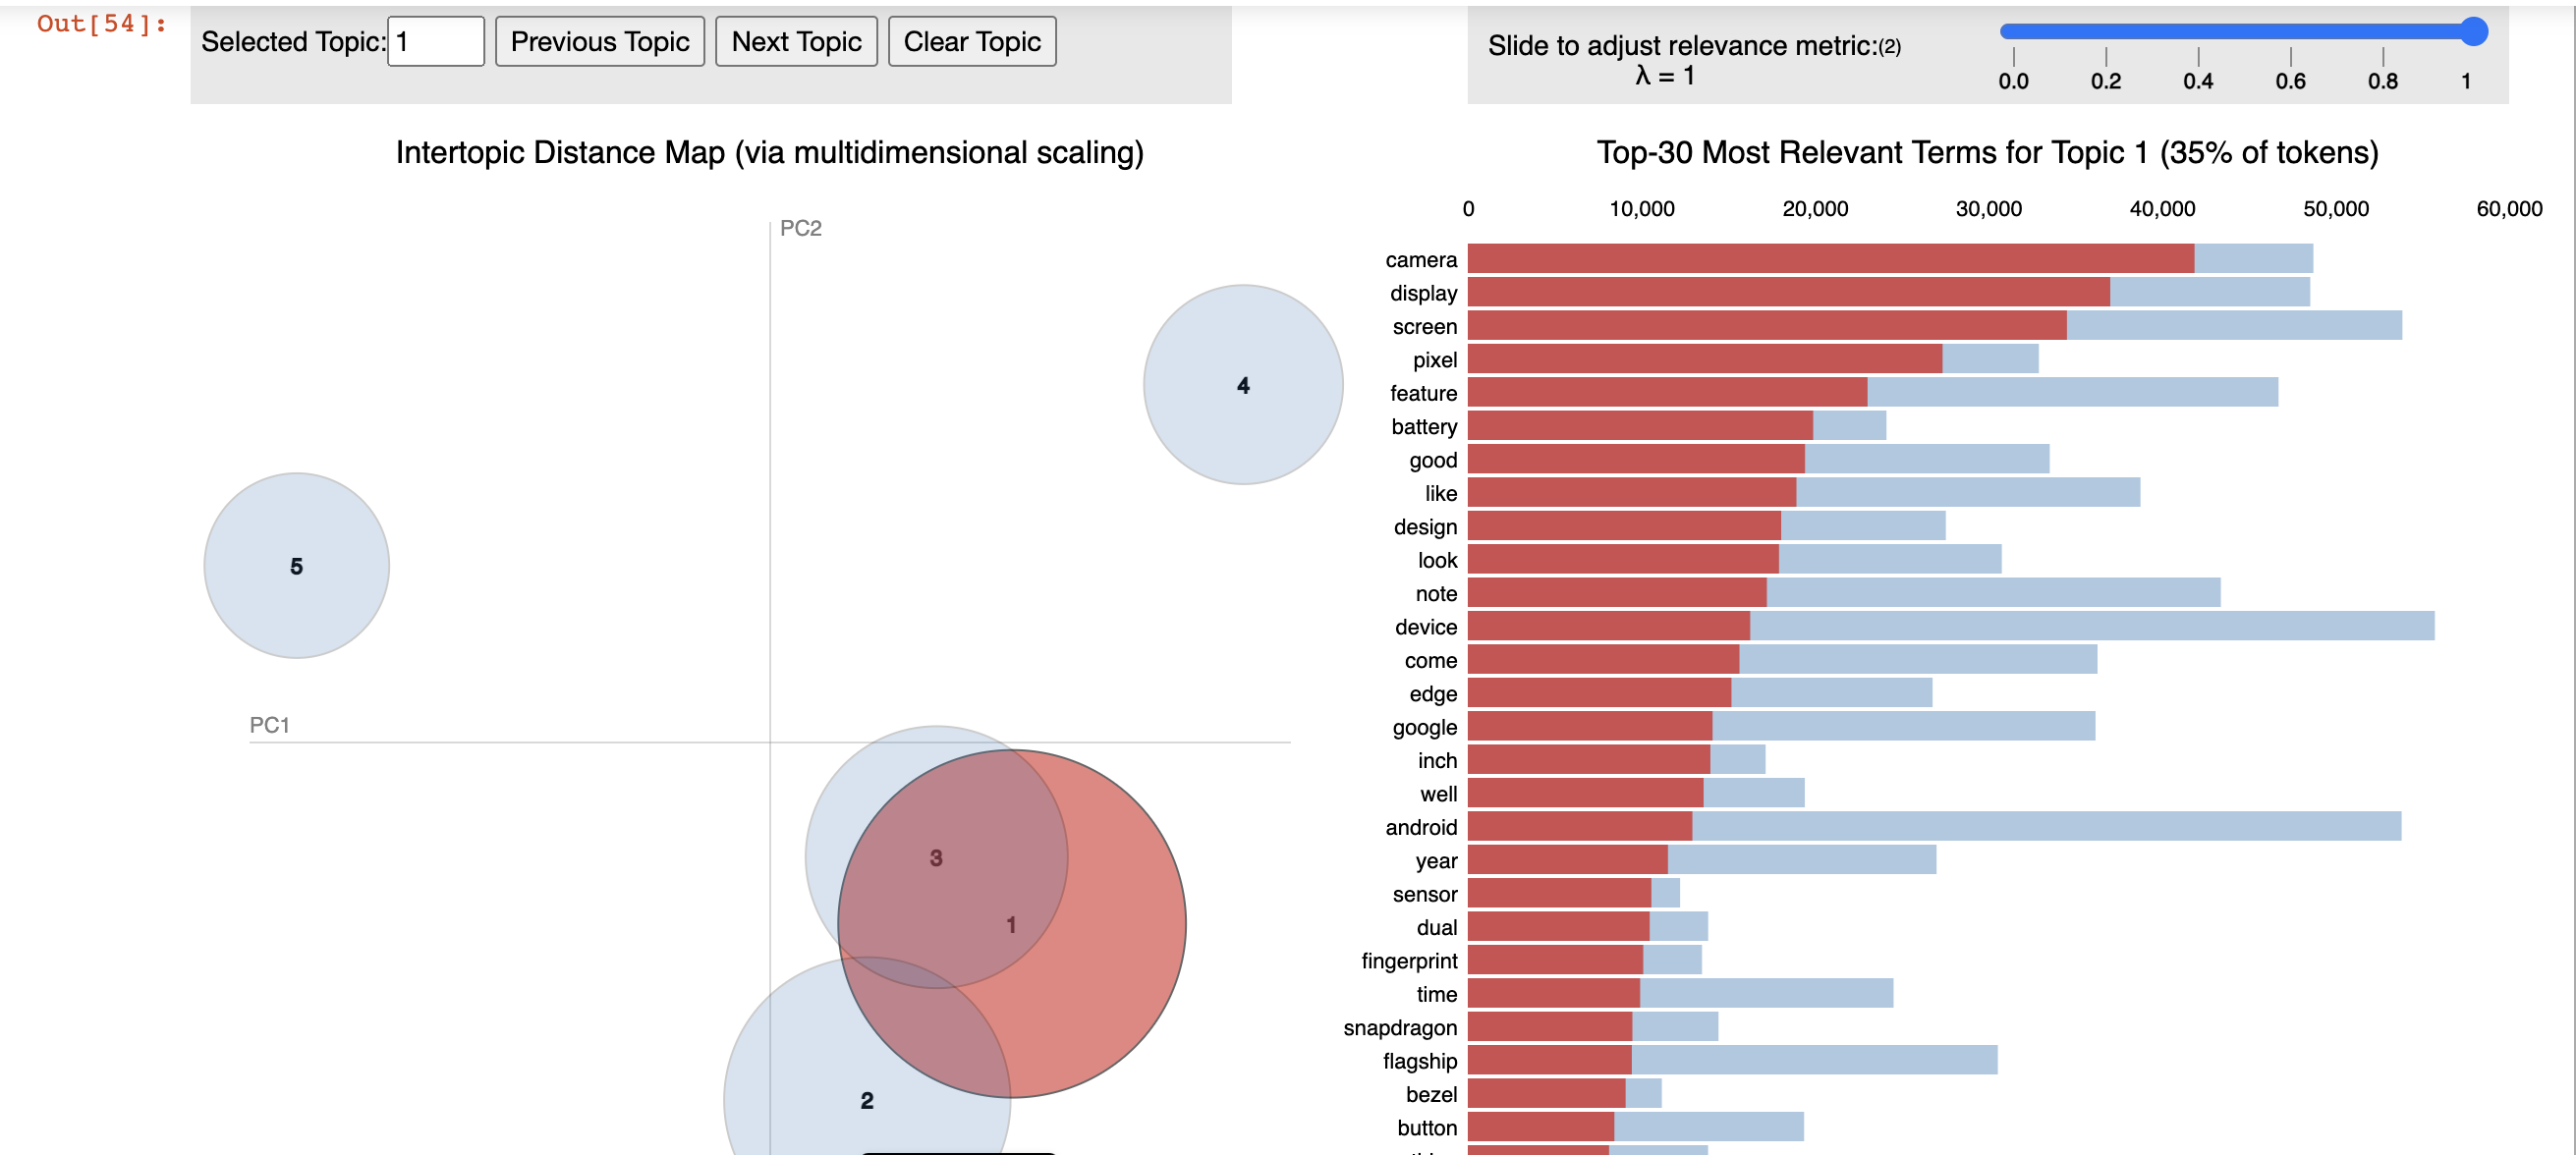

#### After running the cell below, you should see clusters like in the image above.

In [54]:
#Creating Topic Distance Visualization 
plt.rcParams["figure.figsize"] = (12,5)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)

/Users/abhishek/opt/miniconda3/envs/dspm_venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/abhishek/opt/miniconda3/envs/dspm_venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/abhishek/opt/miniconda3/envs/dspm_venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/abhishek/opt/miniconda3/envs/dspm_venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.053431 -0.059791       1        1  35.016322
1     -0.001514 -0.126805       2        1  23.754725
4      0.024820 -0.034502       3        1  19.884702
0      0.141272  0.144902       4        1  11.465538
3     -0.218008  0.076197       5        1   9.878713, topic_info=                   Term          Freq         Total Category  logprob  loglift
79                 case  34813.000000  34813.000000  Default  30.0000  30.0000
46                bixby  32092.000000  32092.000000  Default  29.0000  29.0000
3702                tag  20377.000000  20377.000000  Default  28.0000  28.0000
76              android  58288.000000  58288.000000  Default  27.0000  27.0000
179                news  21216.000000  21216.000000  Default  26.0000  26.0000
233           assistant  16512.000000  16512.000000  Default  25.0000  25.0000
191                tech  17328.000000  17328.000000  Default  24.0000  24.0000
89               screen  58336.000000  58336.000000  Default  23.0000  23.0000
4               twitter  11260.000000  11260.000000  Default  22.0000  22.0000
175              camera  52780.000000  52780.000000  Default  21.0000  21.0000
69                pixel  35647.000000  35647.000000  Default  20.0000  20.0000
61               launch  40578.000000  40578.000000  Default  19.0000  19.0000
234              button  20991.000000  20991.000000  Default  18.0000  18.0000
53                voice  10384.000000  10384.000000  Default  17.0000  17.0000
460            download  11688.000000  11688.000000  Default  16.0000  16.0000
109              google  39182.000000  39182.000000  Default  15.0000  15.0000
132                leak  17926.000000  17926.000000  Default  14.0000  14.0000
25                 2017  32151.000000  32151.000000  Default  13.0000  13.0000
88            protector   6922.000000   6922.000000  Default  12.0000  12.0000
551              update  23406.000000  23406.000000  Default  11.0000  11.0000
28               review  20167.000000  20167.000000  Default  10.0000  10.0000
6218              ifttt   8220.000000   8220.000000  Default   9.0000   9.0000
346               glass  12935.000000  12935.000000  Default   8.0000   8.0000
223             display  52583.000000  52583.000000  Default   7.0000   7.0000
514            flagship  33084.000000  33084.000000  Default   6.0000   6.0000
943             company  24427.000000  24427.000000  Default   5.0000   5.0000
266              gadget   7083.000000   7083.000000  Default   4.0000   4.0000
478               cover   8469.000000   8469.000000  Default   3.0000   3.0000
183          technology  17129.000000  17129.000000  Default   2.0000   2.0000
157              mobile  30161.000000  30161.000000  Default   1.0000   1.0000
15031              ip67    382.543363    383.812656   Topic1  -8.7838   1.0460
18178         telephoto    487.704709    489.343698   Topic1  -8.5410   1.0460
39151              ltps    151.838516    152.622986   Topic1  -9.7079   1.0442
48867              1963    137.685940    138.481670   Topic1  -9.8057   1.0436
9808            unibody    190.527080    191.632530   Topic1  -9.4809   1.0436
48869              6687    135.418976    136.209998   Topic1  -9.8223   1.0435
12085              6084    149.418276    150.347562   Topic1  -9.7239   1.0432
10923        marginally    173.706187    174.829679   Topic1  -9.5733   1.0429
2950               13mp    632.801513    637.050478   Topic1  -8.2805   1.0427
12084              1929    135.612962    136.536118   Topic1  -9.8209   1.0426
15027          basemark    129.978877    130.871881   Topic1  -9.8633   1.0425
5982              crisp    514.607418    518.445497   Topic1  -8.4873   1.0419
17901             quirk    166.119360    167.378190   Topic1  -9.6180   1.0418
3559      stabilization    849.951985    856.432959   Topic1  -7.9855   1.0418
43324              1943 

#### iPhone 8

In [55]:
tpm_lda_df = data_dict_2['Apple iPhone 8']
# Create a id2word dictionary
id2word = corpora.Dictionary(tpm_lda_df['word_tokenize'])
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
corpus = [id2word.doc2bow(d) for d in tpm_lda_df['word_tokenize']]
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=7)

# Filtering for words 
tpm_words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
tpm_topics = [' '.join(t[0:10]) for t in tpm_words]

for _id, t in enumerate(tpm_topics): 
    print(f"------ Topic {_id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
charge wireless tag device twitter news tech update support ifttt

------ Topic 1 ------
camera case charge feature fast glass portrait wireless good like

------ Topic 2 ------
design leak screen rumor display look like camera touch feature

------ Topic 3 ------
watch order store launch say 2017 price year flag irrelevant

------ Topic 4 ------
report year display launch release ole expect analyst feature say



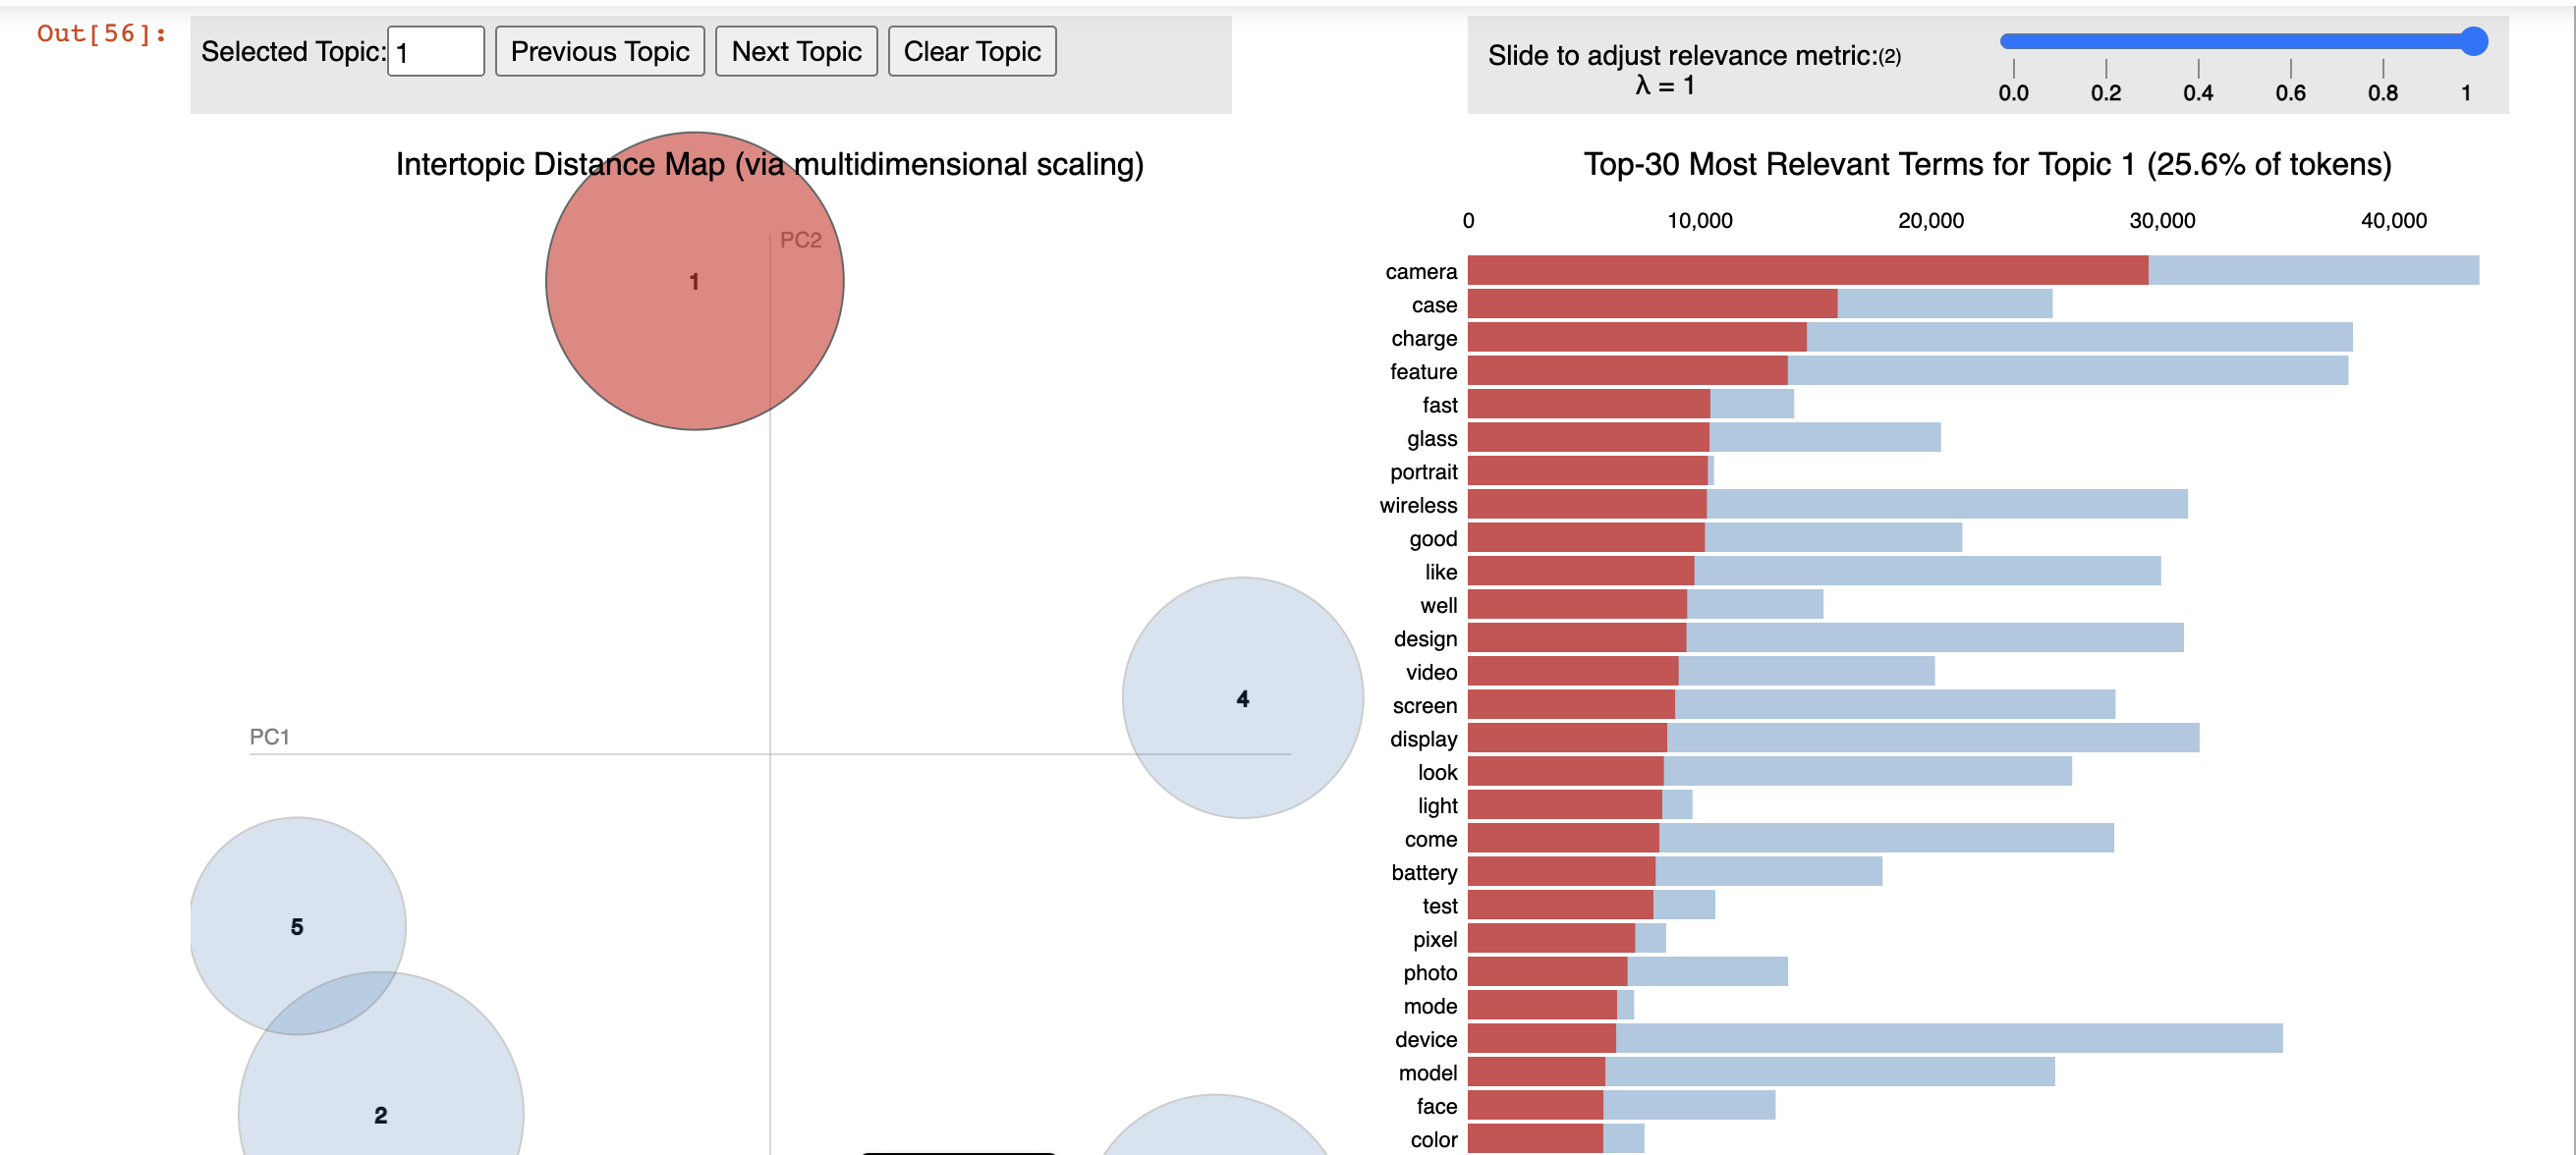

#### After running the cell below, you should see clusters like in the image above.

In [56]:
#Creating Topic Distance Visualization 
plt.rcParams["figure.figsize"] = (12,5)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.016782  0.133602       1        1  25.638650
3     -0.090531 -0.062319       2        1  23.508656
4      0.105507 -0.088885       3        1  20.446047
2      0.112043  0.035625       4        1  16.760131
0     -0.110237 -0.018024       5        1  13.646516, topic_info=                         Term          Freq         Total Category  logprob  \
1                      charge  38250.000000  38250.000000  Default  30.0000   
7                    wireless  31126.000000  31126.000000  Default  29.0000   
4                        leak  18337.000000  18337.000000  Default  28.0000   
91                     camera  43716.000000  43716.000000  Default  27.0000   
4681                      tag  18193.000000  18193.000000  Default  26.0000   
37                     design  30949.000000  30949.000000  Default  25.0000   
50                      rumor  23212.000000  23212.000000  Default  24.0000   
198                    report  27010.000000  27010.000000  Default  23.0000   
31                    analyst  10380.000000  10380.000000  Default  22.0000   
38                    display  31623.000000  31623.000000  Default  21.0000   
27                    twitter  11350.000000  11350.000000  Default  20.0000   
2624                 portrait  10644.000000  10644.000000  Default  19.0000   
43                        ole  15577.000000  15577.000000  Default  18.0000   
214                    screen  27991.000000  27991.000000  Default  17.0000   
4807                    ifttt   7272.000000   7272.000000  Default  16.0000   
61                      touch  16371.000000  16371.000000  Default  15.0000   
80                 production   7945.000000   7945.000000  Default  14.0000   
610                   support  12558.000000  12558.000000  Default  13.0000   
122                    expect  17060.000000  17060.000000  Default  12.0000   
84                       news  21701.000000  21701.000000  Default  11.0000   
4775               irrelevant   7034.000000   7034.000000  Default  10.0000   
1634                     flag   7053.000000   7053.000000  Default   9.0000   
62                      delay   7464.000000   7464.000000  Default   8.0000   
26                       tech  15359.000000  15359.000000  Default   7.0000   
182                   charger   7912.000000   7912.000000  Default   6.0000   
603                     glass  20450.000000  20450.000000  Default   5.0000   
77                     sensor  14385.000000  14385.000000  Default   4.0000   
414                     issue  10237.000000  10237.000000  Default   3.0000   
430                     watch  17771.000000  17771.000000  Default   2.0000   
335                    update  14694.000000  14694.000000  Default   1.0000   
2885                   zazzle   1312.519037   1315.412882   Topic1  -6.9849   
11052                polyvore    282.359468    283.206908   Topic1  -8.5215   
2901                  dxomark   2044.565412   2053.741548   Topic1  -6.5417   
5549                swiftlang    252.800341    253.935411   Topic1  -8.6320   
5414                androbrix    653.031600    656.068147   Topic1  -7.6830   
5546                   ferrer    270.646303    271.919580   Topic1  -8.5638   
964                   yootech    117.583982    118.338729   Topic1  -9.3975   
4122                kickstand    198.180952    199.488869   Topic1  -8.8755   
3791                   floral    163.292820    164.510806   Topic1  -9.0691   
13589                snapseed     99.246508    100.021528   Topic1  -9.5670   
6268                telephoto   1743.832457   1759.928825   Topic1  -6.7008   
5314                 adaptive    133.244636    134.529016   Topic1  -9.2725   
6594              agameoftone     97.578461     98.579141   Topic1  -9.5840   
6595              artofvisual     77.161198     77.966962   Topic1  -9.8187   
15803              foreg

#### iPhone X

In [57]:
tpm_lda_df = data_dict_2['Apple iPhone X']
# Create a id2word dictionary
id2word = corpora.Dictionary(tpm_lda_df['word_tokenize'])
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
corpus = [id2word.doc2bow(d) for d in tpm_lda_df['word_tokenize']]
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=7)

# Filtering for words 
tpm_words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
tpm_topics = [' '.join(t[0:10]) for t in tpm_words]

for _id, t in enumerate(tpm_topics): 
    print(f"------ Topic {_id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
camera screen feature like display look battery year come well

------ Topic 1 ------
camera display pixel note video feature design image screen bionic

------ Topic 2 ------
charge wireless case charger fast feature device support watch design

------ Topic 3 ------
2017 news order watch launch september google event tech year

------ Topic 4 ------
year device model say launch report feature price release company



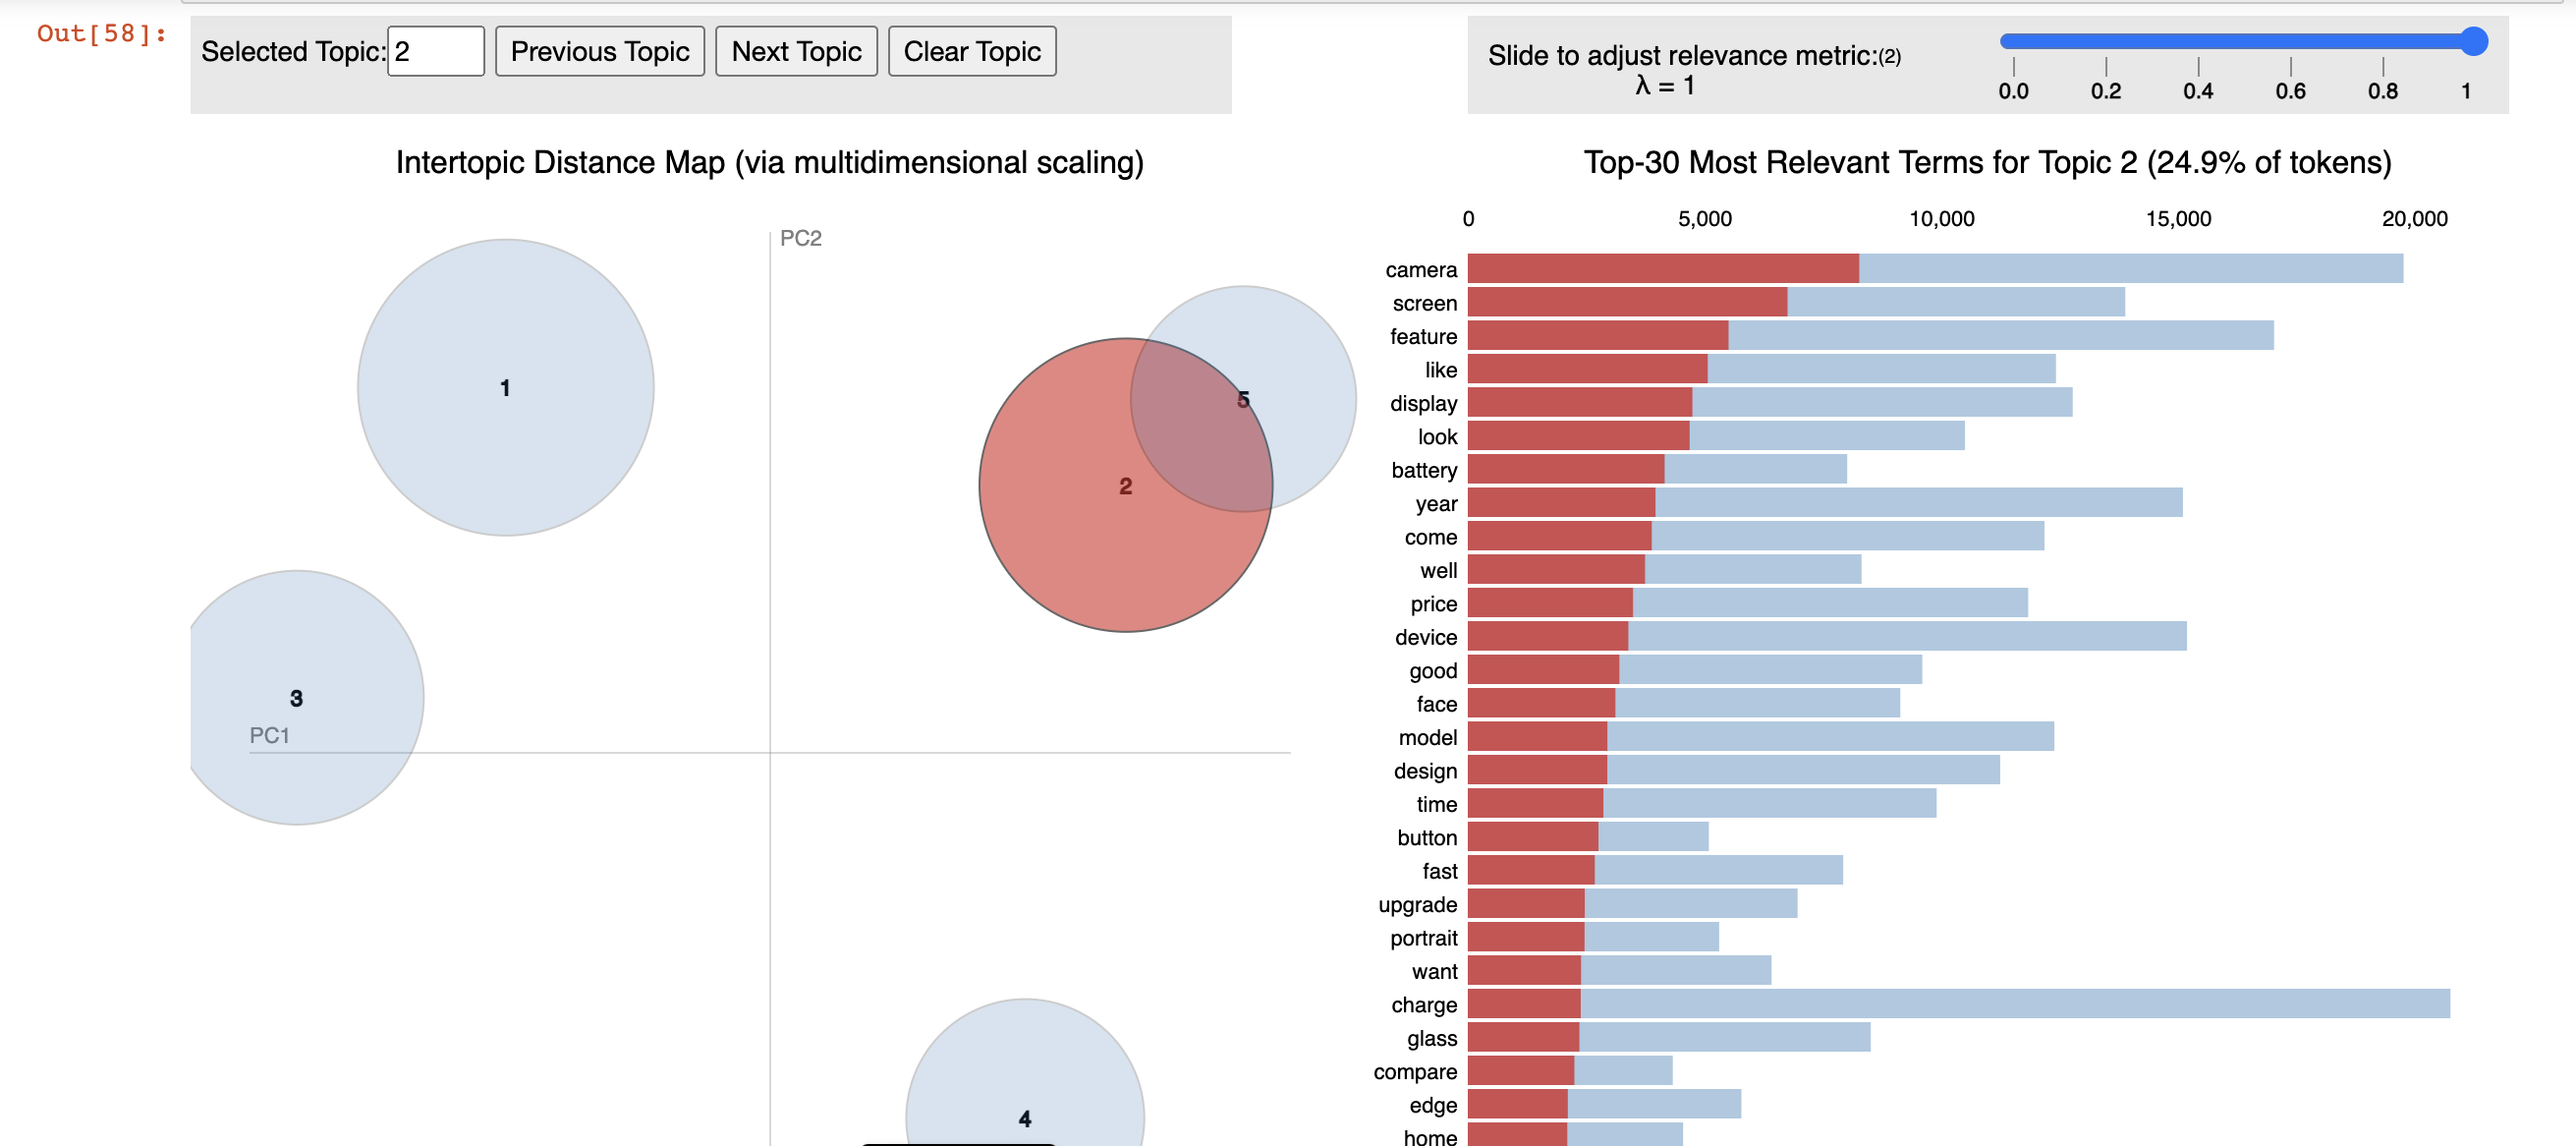

#### After running the cell below, you should see clusters like in the image above

In [58]:
#Creating Topic Distance Visualization 
plt.rcParams["figure.figsize"] = (12,5)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.061891  0.042643       1        1  25.352014
0      0.053157  0.024540       2        1  24.899906
3     -0.100673 -0.014862       3        1  18.648544
2      0.034454 -0.092844       4        1  16.403669
1      0.074954  0.040523       5        1  14.695867, topic_info=                   Term          Freq         Total Category  logprob  loglift
137              charge  20760.000000  20760.000000  Default  30.0000  30.0000
230            wireless  17045.000000  17045.000000  Default  29.0000  29.0000
177              camera  19770.000000  19770.000000  Default  28.0000  28.0000
138             charger   4736.000000   4736.000000  Default  27.0000  27.0000
298                case   7815.000000   7815.000000  Default  26.0000  26.0000
1100              pixel   5323.000000   5323.000000  Default  25.0000  25.0000
20                 news   7144.000000   7144.000000  Default  24.0000  24.0000
108               watch   8132.000000   8132.000000  Default  23.0000  23.0000
63                 fast   7930.000000   7930.000000  Default  22.0000  22.0000
135              report   6198.000000   6198.000000  Default  21.0000  21.0000
14                 2017   9609.000000   9609.000000  Default  20.0000  20.0000
220             display  12779.000000  12779.000000  Default  19.0000  19.0000
116               order   8063.000000   8063.000000  Default  18.0000  18.0000
140             support   6829.000000   6829.000000  Default  17.0000  17.0000
62             charging   3797.000000   3797.000000  Default  16.0000  16.0000
702              bionic   4037.000000   4037.000000  Default  15.0000  15.0000
582            portrait   5311.000000   5311.000000  Default  14.0000  14.0000
243              google   5262.000000   5262.000000  Default  13.0000  13.0000
9                 video   8061.000000   8061.000000  Default  12.0000  12.0000
452                note   6342.000000   6342.000000  Default  11.0000  11.0000
731             analyst   3024.000000   3024.000000  Default  10.0000  10.0000
119               light   5191.000000   5191.000000  Default   9.0000   9.0000
235              launch  11400.000000  11400.000000  Default   8.0000   8.0000
300                chip   4192.000000   4192.000000  Default   7.0000   7.0000
868                 tag   3726.000000   3726.000000  Default   6.0000   6.0000
197               rumor   5063.000000   5063.000000  Default   5.0000   5.0000
1830               core   2524.000000   2524.000000  Default   4.0000   4.0000
87            september   7777.000000   7777.000000  Default   3.0000   3.0000
817                test   3526.000000   3526.000000  Default   2.0000   2.0000
840              sensor   4342.000000   4342.000000  Default   1.0000   1.0000
21924           scooped    109.364876    110.406400   Topic1  -8.5786   1.3628
21925           spinout    101.382707    102.390346   Topic1  -8.6544   1.3624
19381          thepaper    189.098481    191.042555   Topic1  -8.0310   1.3621
19379           surname     64.303521     65.525298   Topic1  -9.1096   1.3535
15816            scorch     64.807232     66.120446   Topic1  -9.1018   1.3523
13419            falter     60.228880     61.517697   Topic1  -9.1751   1.3511
12477         daryanani     50.849460     52.343751   Topic1  -9.3444   1.3433
10333           keybanc    358.727354    369.500310   Topic1  -7.3907   1.3427
3503              dummy    718.770838    740.541889   Topic1  -6.6957   1.3425
3624             geskin    628.557444    648.651571   Topic1  -6.8298   1.3408
21198          insights     48.822430     50.407776   Topic1  -9.3851   1.3404
21065            natale    120.392254    124.334852   Topic1  -8.4825   1.3401
22373        z8mh7b7z4r     83.860989     86.640769   Topic1  -8.8441   1.3397
14744         explosion     91.546514     94.641529   Topic1  -8.7564   1.3391
13478        respondent 